### Imports

In [1]:
#data 
import os

#data
import pandas as pd
import numpy as np

#HTML
from IPython.display import HTML

#traitement
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

#visualistaion
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib as mpl 
mpl.rcdefaults()
sns.set()
sns.set_theme(palette="deep")
sns.set_style("whitegrid")
sns.set_palette("colorblind")
plt.rcParams['grid.linestyle'] = ':'

### Database

In [3]:
import os
os.getcwd()

'/home/bryan/datascience/seatle/notebook'

In [4]:
source = '/home/bryan/datascience/seatle/data/source/'
filename = '2016_Building_Energy_Benchmarking.csv'
df = pd.read_csv(source + filename)

In [5]:
df_M = df.copy()

# 1 - VISUALISATION RAPIDE

In [6]:
df_M.shape

(3376, 46)

In [7]:
df_M.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [8]:
df_M.head(5)

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

## 1.1 - Types de variables

In [9]:
type_counts = df.dtypes.value_counts()

In [10]:
df_dtype = pd.DataFrame({'DataType': [22,1,8,15]}, index=['Float', 'Bool','int64','Object'])
df_dtype = df_dtype.sort_values(by = 'DataType')
df_dtype

DataType
Bool           1
int64          8
Object        15
Float         22

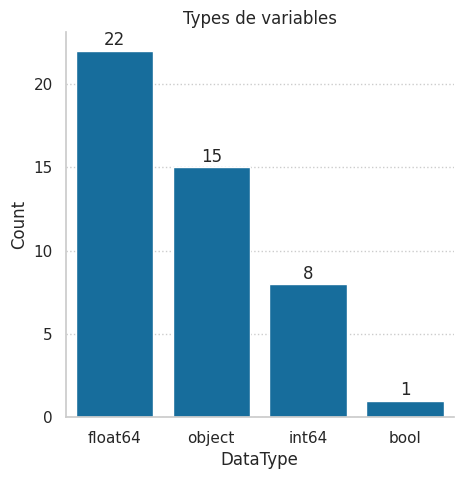

In [11]:
#Préparation des données pour seaborn
data_for_plot = type_counts.reset_index()
data_for_plot.columns = ['DataType', 'Count']

#graphique
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.barplot(x = 'DataType', y = 'Count', data = data_for_plot)
sns.despine()

plt.title('Types de variables')
for container in ax.containers:
    ax.bar_label(container, padding = 1)

## 1.2 - Distribution des valeurs manquantes

<Axes: >

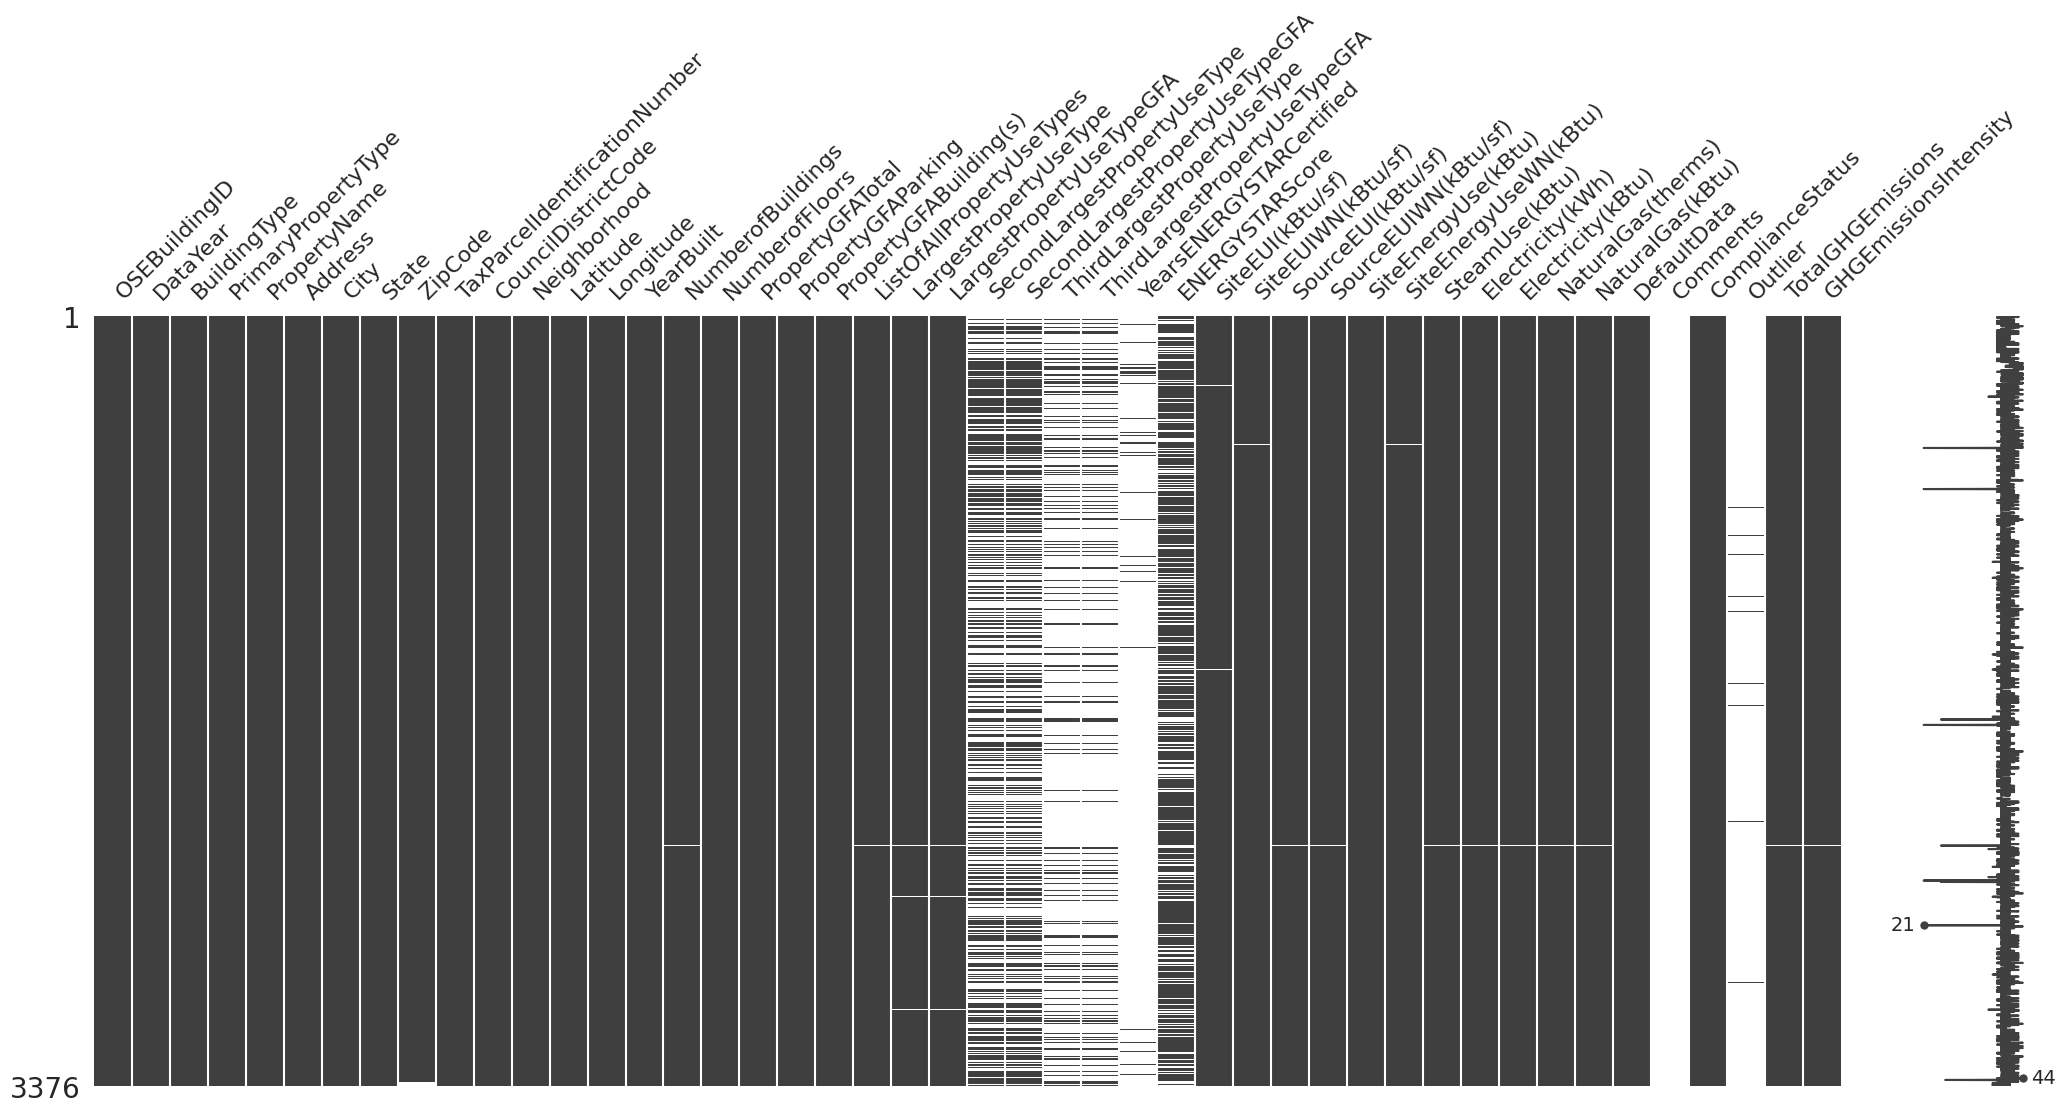

In [12]:
msno.matrix(df_M)

# 2 - NETOYAGE

## 2.1 - Doublons

In [13]:
df_M.duplicated(subset = 'OSEBuildingID').sum()

0

## 2.2 - Selection des batiments non résidentiels

### 2.2.1 - Identifications des differents types de batiments

In [14]:
df.loc[:, 'BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

Pour selectionner les batiments non résidentiels nous allons identifier les differents types.
Nous allons utiliser la colonne ListOfAllPropertyUseTypes.
Nous remarquons qu'un meme batiment peu avoir plusieurs utilisations.
Nous pouvons avoir un batiment qui contient des bureaux, des appartements residentiels et autres.(voir ci-dessous)

In [15]:
df_M.shape

(3376, 46)

In [16]:
df_M['ListOfAllPropertyUseTypes'].head(5)

0                            Hotel
1       Hotel, Parking, Restaurant
2                            Hotel
3                            Hotel
4    Hotel, Parking, Swimming Pool
Name: ListOfAllPropertyUseTypes, dtype: object

### 2.2.2 - Uniformisation textuelle

In [17]:
X = df_M['ListOfAllPropertyUseTypes'].fillna('').str.replace(r"\s*,\s*", ",", regex=True)

In [18]:
vectorizer = CountVectorizer(token_pattern= '(?u)[a-zA-Z0-9-/\s]+')
wm_AllUseType = vectorizer.fit_transform(X)
tokens_AllUseType = vectorizer.get_feature_names_out()

In [19]:
dense_matrix = wm_AllUseType.toarray()
print(dense_matrix.shape)

(3376, 76)


In [20]:
print(tokens_AllUseType)

[' surgical' 'adult education' 'automobile dealership' 'bank branch'
 'bar/nightclub' 'college/university'
 'convenience store without gas station' 'convention center' 'courthouse'
 'data center' 'distribution center' 'dry cleaning' 'enclosed mall'
 'energy/power station' 'etc' 'fast food restaurant' 'financial office'
 'fire station' 'fitness center/health club/gym' 'food sales'
 'food service' 'general medical ' 'health/beauty' 'hospital ' 'hotel'
 'k-12 school' 'laboratory' 'library' 'lifestyle center' 'locksmith'
 'manufacturing/industrial plant' 'medical office' 'movie theater'
 'multifamily housing' 'museum' 'non-refrigerated warehouse' 'office'
 'other' 'other - education' 'other - entertainment/public assembly'
 'other - lodging/residential' 'other - mall' 'other - public services'
 'other - recreation' 'other - restaurant/bar' 'other - services'
 'other - technology/science' 'other - utility' 'other/specialty hospital'
 'outpatient rehabilitation/physical therapy' 'parking' 'p

In [21]:
count_liste = wm_AllUseType.toarray().sum(axis=0)

In [22]:
df_graph = pd.DataFrame({
    'AllUseType': tokens_AllUseType,
    'frequence' : count_liste
})

df_graph = df_graph.sort_values(by='frequence', ascending=False)
df_graph

AllUseType  frequence
33         multifamily housing       1707
50                     parking       1087
36                      office        861
61                retail store        404
35  non-refrigerated warehouse        261
..                         ...        ...
13        energy/power station          1
72                       vocat          1
59   residential care facility          1
74  wholesale club/supercenter          1
17                fire station          1

[76 rows x 2 columns]

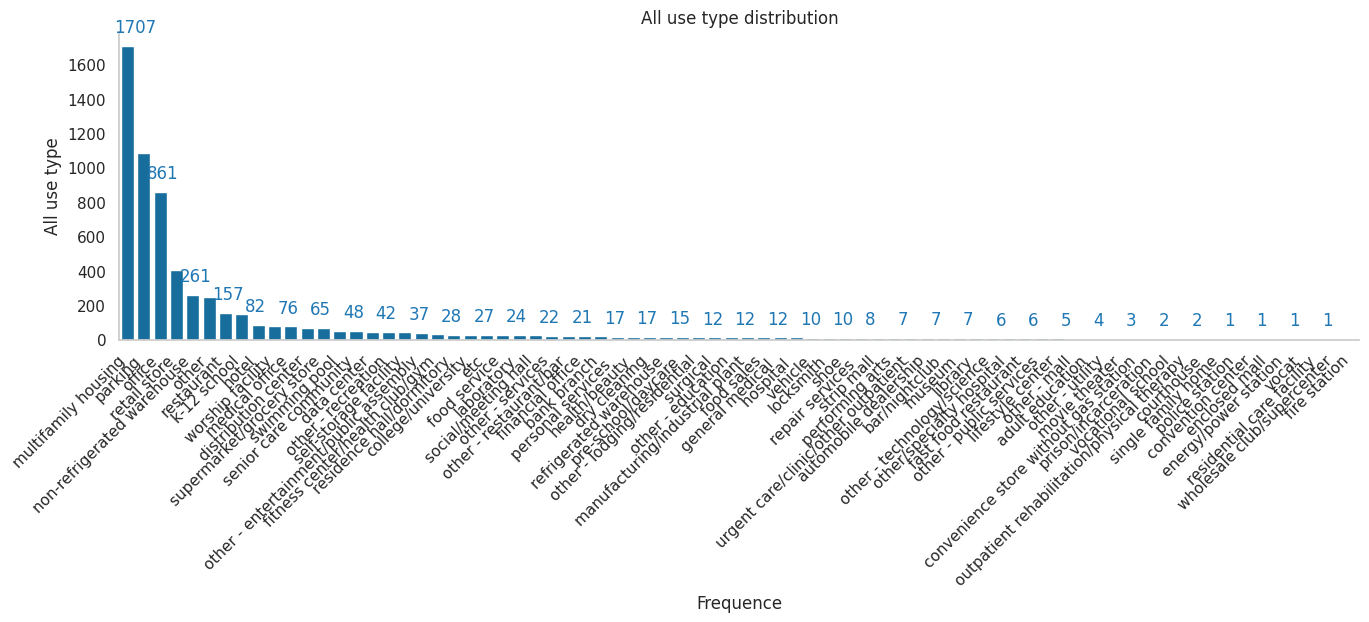

In [23]:
fig , ax = plt.subplots(1,1,figsize = (16,4))
sns.barplot(data = df_graph, x='AllUseType', y='frequence')
sns.despine()
plt.grid(False)

plt.title('All use type distribution')
plt.xlabel('Frequence')
plt.ylabel('All use type')

#for container in ax.containers:
#    ax.bar_label(container, padding=1, color = 'tab:blue', size = 10)

freq = df_graph['frequence'].tolist()
for i in np.arange(0, len(df_graph),2 ):
    plt.text(i-0.8, freq[i]+80, freq[i], color = 'tab:blue')
    
for xtick in ax.xaxis.get_ticklabels():
        #xtick.set_color('tab:blue')
        #xtick.set_fontsize(11)
        xtick.set_rotation(45)
        xtick.set_ha('right')

plt.show()

SéparationA quels types de modalités correspondent les batiments residentiels?
Nous avons consideré les 'Multifamily Housing' et 'Résidence Hall/Dormitory' comme résidentiel.
Nous avons exclu 'Lodging/Residential' qui se réfère plus à une activité d'hotellerie.

### 2.2.3 - Séparation des batiments non-résidentiels et résidentiels

#### Etape 1 : contrôle des données GFA

In [24]:
listeGFA = ['PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)','LargestPropertyUseTypeGFA',
            'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']
df_M[listeGFA].describe().round(0)

PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
count            3376.0              3376.0                  3376.0   
mean            94834.0              8002.0                 86832.0   
std            218838.0             32327.0                207940.0   
min             11285.0                 0.0                  3636.0   
25%             28487.0                 0.0                 27756.0   
50%             44175.0                 0.0                 43216.0   
75%             90992.0                 0.0                 84276.0   
max           9320156.0            512608.0               9320156.0   

       LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
count                     3356.0                           1679.0   
mean                     79178.0                          28444.0   
std                     201703.0                          54393.0   
min                       5656.0                              0.0   
25%                      25095.0                           5000.0   
50%                      39894.0                          10664.0   
75%                      76200.0                          26640.0   
max                    9320156.0                         686750.0   

       ThirdLargestPropertyUseTypeGFA  
count                           596.0  
mean                          11739.0  
std                           29331.0  
min                               0.0  
25%                            2239.0  
50%                            5043.0  
75%                           10139.0  
max                          459748.0

In [25]:
#On contrôle la coherence des calculs des surfaces
X = df_M['PropertyGFATotal'] - (df_M['PropertyGFABuilding(s)'] + df_M['PropertyGFAParking'])
X.sum()

0

#### Etape 2 : séléction des batimens résidentiels

Nous rapellons qu'un batiment peu etre utilisé en partie dans un but résidentiel et non résidentiels!
Création de 3 colonnes pour regarder si le batiment est utilisé soit pour des 'Multifamily Housing' OU 'Residence Hall/Dormitory' pour chacune des colonnes suivantes largest, second et troisieme type d'utilisation.

In [26]:
liste = ['Multifamily Housing','Residence Hall/Dormitory']
df_M['check_resid_largest']=[1 if any(w in x for w in liste) else 0 for x in df_M['LargestPropertyUseType'].apply(lambda s: str(s))]
df_M['check_resid_Slargest']=[1 if any(w in x for w in liste) else 0 for x in df_M['SecondLargestPropertyUseType'].apply(lambda s: str(s))]
df_M['check_resid_Tlargest']=[1 if any(w in x for w in liste) else 0 for x in df_M['ThirdLargestPropertyUseType'].apply(lambda s: str(s))]

In [27]:
#verification pour LargestPropertyUseType
cond1 = df_M['LargestPropertyUseType'] == 'Multifamily Housing'
cond2 = df_M['LargestPropertyUseType'] == 'Residence Hall/Dormitory'
print(df_M['check_resid_largest'].sum(), len(df_M[(cond1)|(cond2)]))

#verification pour SecondPropertyUseType
cond1 = df_M['SecondLargestPropertyUseType'] == 'Multifamily Housing'
cond2 = df_M['SecondLargestPropertyUseType'] == 'Residence Hall/Dormitory'
print(df_M['check_resid_Slargest'].sum(), len(df_M[(cond1)|(cond2)]))

#verification pour ThirdPropertyUseType
cond1 = df_M['ThirdLargestPropertyUseType'] == 'Multifamily Housing'
cond2 = df_M['ThirdLargestPropertyUseType'] == 'Residence Hall/Dormitory'
print(df_M['check_resid_Tlargest'].sum(), len(df_M[(cond1)|(cond2)]))

1691 1691
19 19
13 13


In [28]:
# Define the residential property types to check for
residential_property_types = ['Multifamily Housing', 'Residence Hall/Dormitory']

# Define a function to perform the check for a given column and return the result
def check_residential_properties(column):
    return column.apply(lambda x: any(w in str(x) for w in residential_property_types))

# Verify the results for each property type column
print(df_M['check_resid_largest'].sum(), len(df_M[check_residential_properties(df_M['LargestPropertyUseType'])]))
print(df_M['check_resid_Slargest'].sum(), len(df_M[check_residential_properties(df_M['SecondLargestPropertyUseType'])]))
print(df_M['check_resid_Tlargest'].sum(), len(df_M[check_residential_properties(df_M['ThirdLargestPropertyUseType'])]))

1691 1691
19 19
13 13


remarque:
Nous avons 1691 batiments qui sont utilisés comme batiments résidentiels mais qui peuvent ou non avoir une activité secondaire ou une troisieme activité autres que résidentiels.
Nous avons 19 batiments qui ont une activité residentiel comme activité secondaire et sont utilisés principalement pour un autre type d'activité.
Nous avons 13 batiments qui ont une activité residentiel comme activité tertiaire et sont utilisés principalement pour un autre type d'activité.

#### Etape 3 : NonResidentialGFA

Création d'une colonne qui récupère la surface du batiment qui est utilisée de manière non résidentiel.

In [29]:
df_M['GFA'] = (df_M['LargestPropertyUseTypeGFA'].fillna(0) + 
               df_M['SecondLargestPropertyUseTypeGFA'].fillna(0) +
               df_M['ThirdLargestPropertyUseTypeGFA'].fillna(0))

In [30]:
#creation de la colonne 'NonResidentialGFA'
Largest_R = df_M['check_resid_largest']*df_M['LargestPropertyUseTypeGFA']
SLargest_R = df_M['check_resid_Slargest']*df_M['SecondLargestPropertyUseTypeGFA']
TLargest_R = df_M['check_resid_Tlargest']*df_M['ThirdLargestPropertyUseTypeGFA']
df_M['NonResidentialGFA'] = df_M['GFA'] -(Largest_R.fillna(0) + SLargest_R.fillna(0) + TLargest_R.fillna(0))
df_M = df_M.astype({'NonResidentialGFA': int})

In [31]:
df_M.drop('GFA', axis = 1, inplace = True)

#### Etape 4 : Selection des batiments uniquement résidentiels

Récuperation des indices des batiments qui sont UNIQUEMENT utilisés comme batiments résidentiel.

In [32]:
RqdIndexBatRes = df_M[df_M.loc[:,'NonResidentialGFA']==0].index.tolist()
len(RqdIndexBatRes)

936

In [33]:
df_M['NonResidentialGFA'].describe().round(0)

count       3376.0
mean       64981.0
std       222538.0
min            0.0
25%            0.0
50%        23100.0
75%        54054.0
max      9320156.0
Name: NonResidentialGFA, dtype: float64

In [34]:
#verification du nombre de batiment qui sont uniquement des batiments résidentiel
cond1 = df['LargestPropertyUseType'] == 'Multifamily Housing'
cond1B = df['LargestPropertyUseType'] == 'Residence Hall/Dormitory'
cond2 = df['SecondLargestPropertyUseType'].isna()
cond3 = df['ThirdLargestPropertyUseType'].isna()
print('uniquement Multifamily Housing', len(df[(cond1)&(cond2)&(cond3)]))
print('uniquement Residence Hall/Dormitory', len(df[(cond1B)&(cond2)&(cond3)]))

uniquement Multifamily Housing 856
uniquement Residence Hall/Dormitory 16


In [35]:
print(f"avant supression : {df_M.shape}")
#supression des batiment uniquement résidentiel
df_M.drop(RqdIndexBatRes, axis = 0, inplace = True)
#supression des colonne créees pour durant le process
liste_temp = ['check_resid_largest','check_resid_Slargest','check_resid_Tlargest']
df_M.drop(liste_temp, axis = 1, inplace = True)
print(f"apres supression : {df_M.shape}")

avant supression : (3376, 50)
apres supression : (2440, 47)


## 2.3 - Outlier et ComplianceStatus

In [36]:
df_M['Outlier'].unique()

array([nan, 'High outlier', 'Low outlier'], dtype=object)

In [37]:
cond1 = df_M['Outlier'] == ('High outlier')
cond2 = df_M['Outlier'] == ('Low outlier')
print(f"le nombre d'outlier est de : {len(df_M[cond1 |cond2])}")
HTML(df_M[cond1 |cond2].head(5).to_html())

le nombre d'outlier est de : 26


In [38]:
df_M.groupby('ComplianceStatus')[['ComplianceStatus','Outlier']].count()

ComplianceStatus  Outlier
ComplianceStatus                                       
Compliant                                 2303        0
Error - Correct Default Data                97        2
Missing Data                                15        0
Non-Compliant                               25       24

In [39]:
#supression des outliers
rqdIndex = df_M[cond1 |cond2].index
df_M.drop(rqdIndex, axis = 0, inplace = True)

In [40]:
df_M.shape

(2414, 47)

## 2.4 - Selection colonnes

In [41]:
#suppression des champs
liste = ['OSEBuildingID','DataYear','Address','City', 'State', 'ZipCode','PropertyName',
         'ListOfAllPropertyUseTypes','TaxParcelIdentificationNumber','Comments','YearsENERGYSTARCertified']
df_M.drop(liste, axis = 1, inplace = True)

In [42]:
df_M.shape

(2414, 36)

## 2.5 - Valeurs manquantes et traitement

In [43]:
for i in zip(df_M.columns,df_M.isna().sum(axis = 0)):
    if i[1] > 0:
        print(i)

('SecondLargestPropertyUseType', 795)
('SecondLargestPropertyUseTypeGFA', 795)
('ThirdLargestPropertyUseType', 1827)
('ThirdLargestPropertyUseTypeGFA', 1827)
('ENERGYSTARScore', 757)
('SiteEUI(kBtu/sf)', 1)
('SiteEUIWN(kBtu/sf)', 1)
('SiteEnergyUseWN(kBtu)', 1)
('Outlier', 2414)


In [44]:
df_M.isna().sum().sort_values(ascending = False).head(10)

Outlier                            2414
ThirdLargestPropertyUseTypeGFA     1827
ThirdLargestPropertyUseType        1827
SecondLargestPropertyUseTypeGFA     795
SecondLargestPropertyUseType        795
ENERGYSTARScore                     757
SiteEnergyUseWN(kBtu)                 1
SiteEUI(kBtu/sf)                      1
SiteEUIWN(kBtu/sf)                    1
Electricity(kBtu)                     0
dtype: int64

In [45]:
#PropertyUseType --> unknown
df_M['SecondLargestPropertyUseType'].fillna('NotOtherUse')
df_M['ThirdLargestPropertyUseType'].fillna('NotOtherUse')
#ENERGYSTARScore --> Nan
#PropertyUseTypeGFA --> 0
df_M['SecondLargestPropertyUseTypeGFA'].fillna(0)
df_M['ThirdLargestPropertyUseTypeGFA'].fillna(0)
#SiteEUI --> suppression de l'observation
rqdIndex = df_M[df_M['SiteEUI(kBtu/sf)'].isna()].index
df_M.drop(rqdIndex, axis = 0, inplace = True )

In [46]:
df_M.shape

(2413, 36)

# 3 - EXPLORATION

##  3.1 - Variables qualitatives

In [47]:
df_MQ = df_M.select_dtypes(include= 'object')
df_MQ.shape

(2413, 8)

In [48]:
df_MQ.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 2413 entries, 0 to 3375
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   BuildingType                  2413 non-null   object
 1   PrimaryPropertyType           2413 non-null   object
 2   Neighborhood                  2413 non-null   object
 3   LargestPropertyUseType        2413 non-null   object
 4   SecondLargestPropertyUseType  1618 non-null   object
 5   ThirdLargestPropertyUseType   587 non-null    object
 6   ComplianceStatus              2413 non-null   object
 7   Outlier                       0 non-null      object
dtypes: object(8)
memory usage: 169.7+ KB


### 3.1.1 - Descrition des variables

In [49]:
#on regarde le nombre de modalités pour chacune de ces variables qualitatives
for champ in df_MQ:
    print(f"pour le champ : {champ} nous avons : {df_MQ[champ].nunique()} modalités")

pour le champ : BuildingType nous avons : 8 modalités
pour le champ : PrimaryPropertyType nous avons : 24 modalités
pour le champ : Neighborhood nous avons : 19 modalités
pour le champ : LargestPropertyUseType nous avons : 55 modalités
pour le champ : SecondLargestPropertyUseType nous avons : 50 modalités
pour le champ : ThirdLargestPropertyUseType nous avons : 44 modalités
pour le champ : ComplianceStatus nous avons : 3 modalités
pour le champ : Outlier nous avons : 0 modalités


### 3.1.2 - Distribution des modalités

#### fonction pour la creation de graphiques

In [89]:
def graph_distribution_modalités(df,champ,
                                figsize = (8,4),
                                label_size = 12,
                                container_size = 12,
                                title_size = 15, rotation = 45):
    
    X = np.array([df.loc[:,champ].value_counts().values])
    columns = df.loc[:,champ].value_counts().index
    df_graph = pd.DataFrame(data = X, columns = columns)

    fig, ax = plt.subplots(1,1, figsize = figsize)

    g = sns.barplot(data =df_graph, ax = ax)

    for container in ax.containers:
        ax.bar_label(container, padding=1, color = 'tab:blue', size = container_size)
    
            
    for xlabel in ax.xaxis.get_ticklabels():
        xlabel.set_color('tab:blue')
        xlabel.set_rotation(rotation)
        xlabel.set_ha('right')
        xlabel.set_fontsize(label_size)

    for ylabel in ax.yaxis.get_ticklabels():
        ylabel.set_color('tab:blue')
        ylabel.set_fontsize(label_size)
    
    liste_height_bar = []
    for bar in ax.patches:
        liste_height_bar.append(bar.get_height())
        max_height = max(liste_height_bar)

    plt.ylim(0, max_height*(1.15))
    plt.title(f"{champ} distribution", color = 'tab:blue', fontsize = title_size)
    sns.despine()
    plt.show()

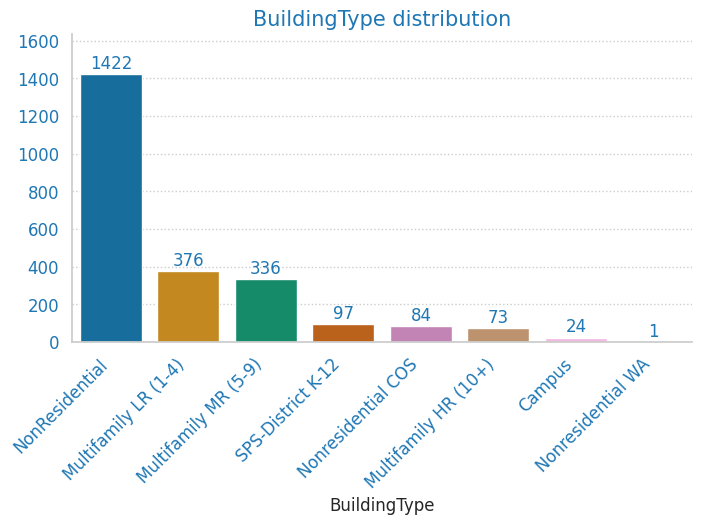

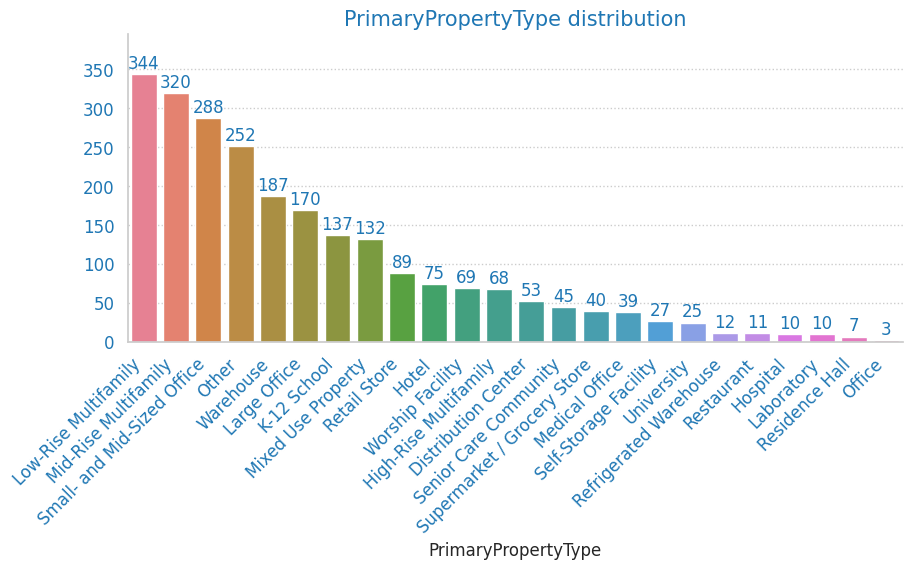

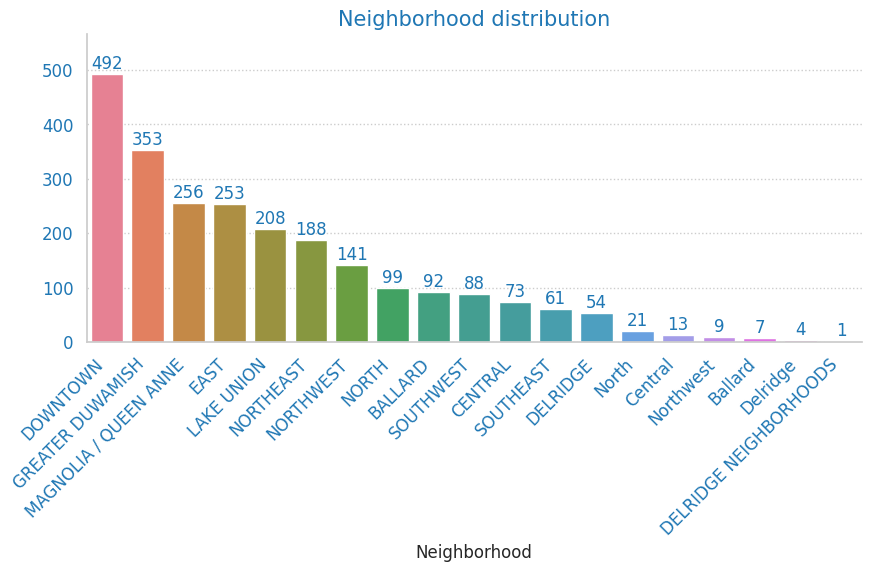

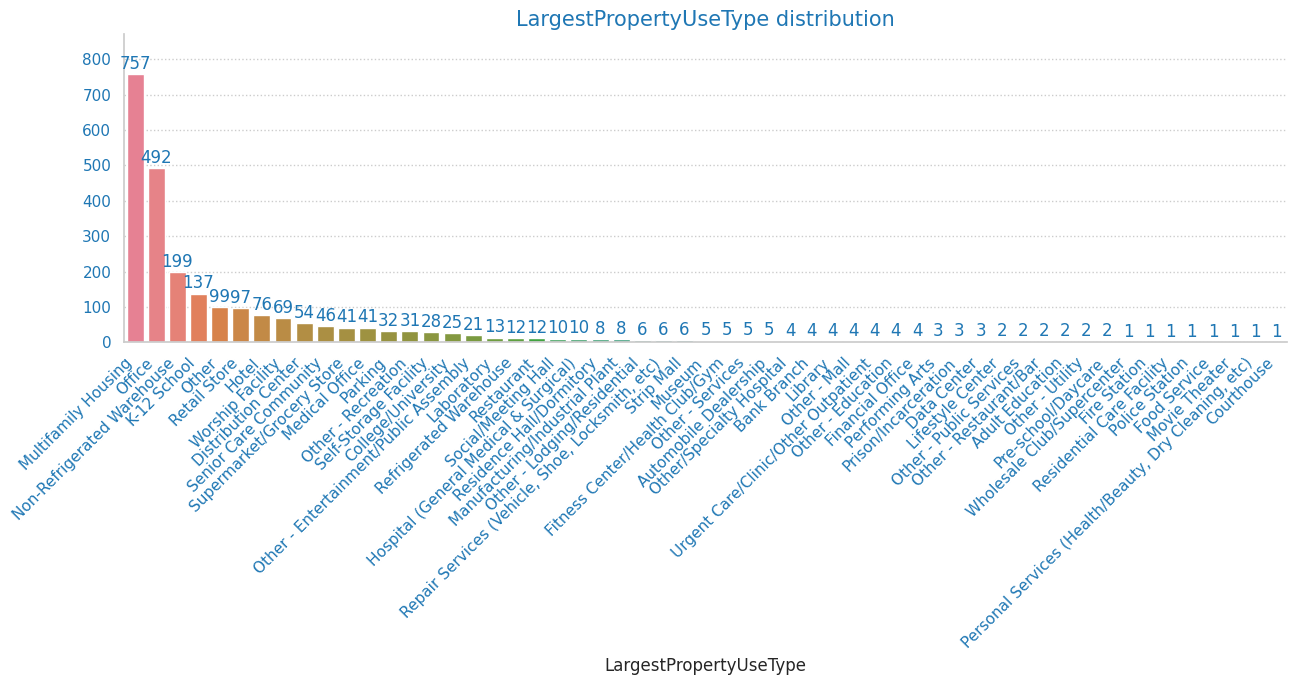

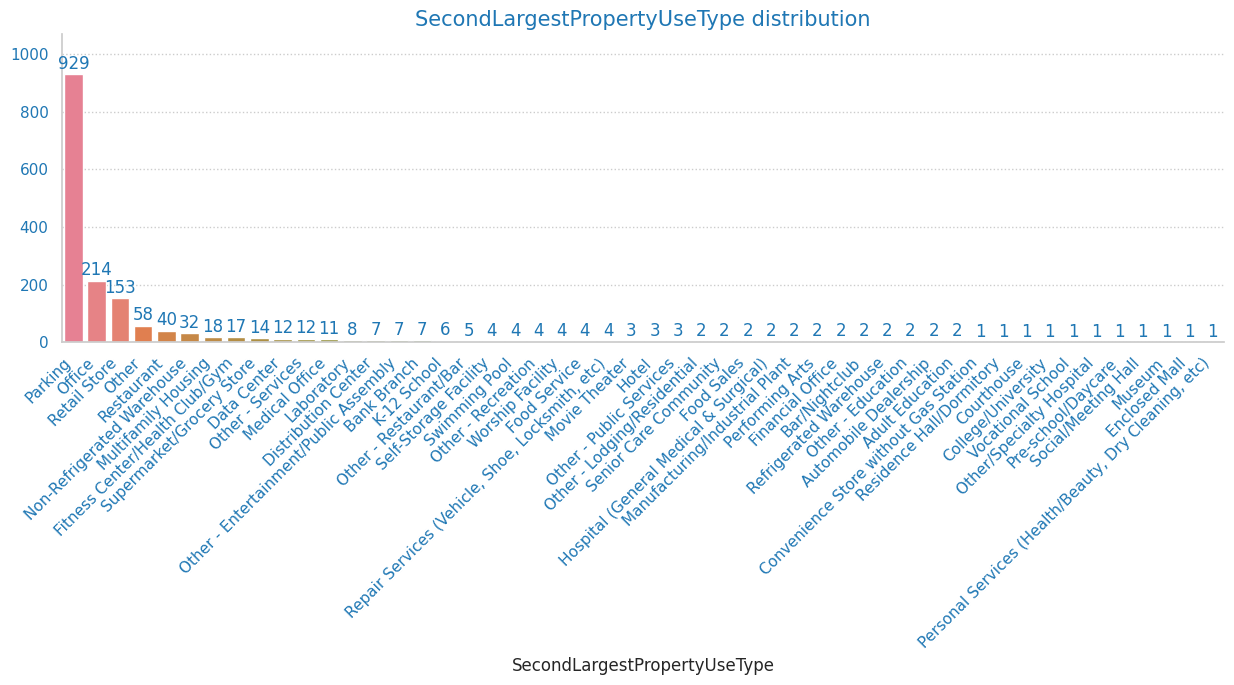

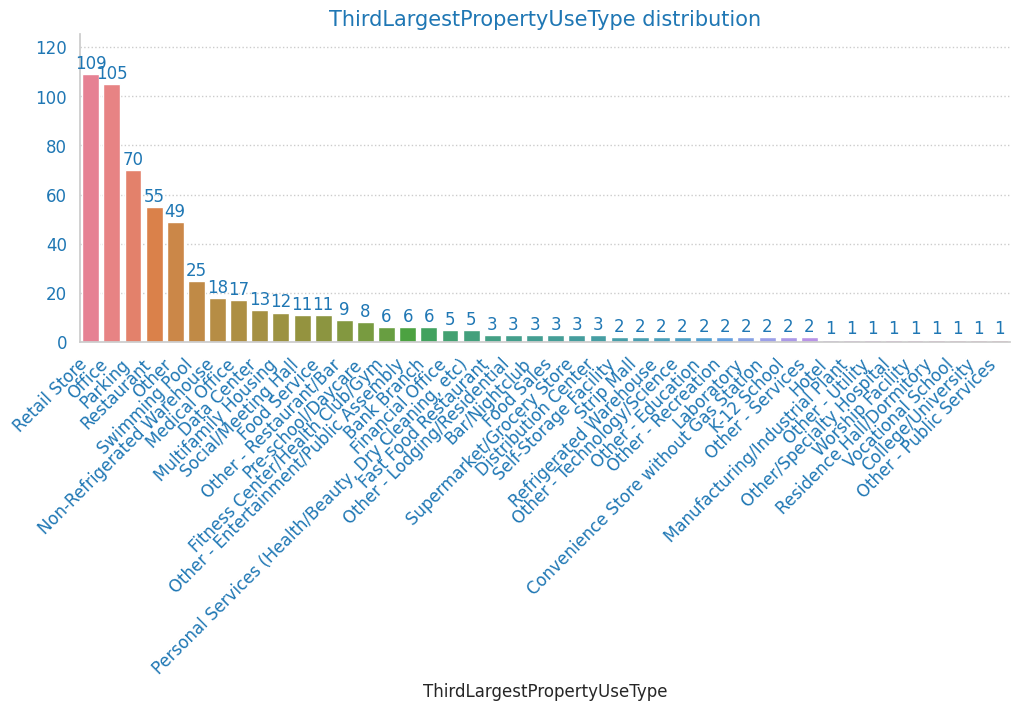

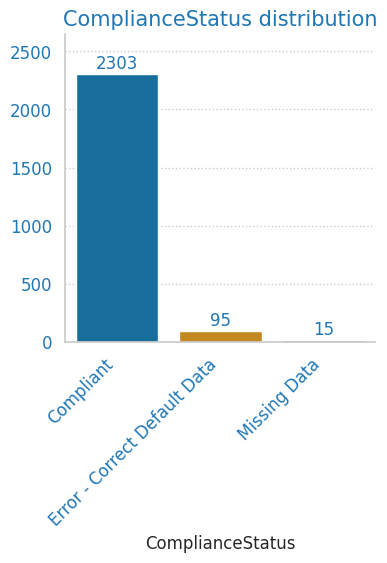

In [90]:
graph_distribution_modalités(df_MQ, champ = 'BuildingType', figsize = (8,4))
graph_distribution_modalités(df_MQ, champ = 'PrimaryPropertyType', figsize = (10,4))
graph_distribution_modalités(df_MQ, champ = 'Neighborhood', figsize = (10,4))
graph_distribution_modalités(df_MQ, champ = 'LargestPropertyUseType', figsize = (15,4), label_size = 11)
graph_distribution_modalités(df_MQ, champ = 'SecondLargestPropertyUseType', figsize = (15,4), label_size = 11)
graph_distribution_modalités(df_MQ, champ = 'ThirdLargestPropertyUseType', figsize = (12,4))
graph_distribution_modalités(df_MQ, champ = 'ComplianceStatus', figsize = (4,4))

## 3.2 - Variables integer

In [52]:
df_MI = df_M.select_dtypes(include='int64').join(df_M[['Latitude', 'Longitude']],
                                                 lsuffix="_left", rsuffix="_right")
df_MI.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 2413 entries, 0 to 3375
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CouncilDistrictCode     2413 non-null   int64  
 1   YearBuilt               2413 non-null   int64  
 2   NumberofFloors          2413 non-null   int64  
 3   PropertyGFATotal        2413 non-null   int64  
 4   PropertyGFAParking      2413 non-null   int64  
 5   PropertyGFABuilding(s)  2413 non-null   int64  
 6   NonResidentialGFA       2413 non-null   int64  
 7   Latitude                2413 non-null   float64
 8   Longitude               2413 non-null   float64
dtypes: float64(2), int64(7)
memory usage: 188.5 KB


### 3.2.1 - Descrition des variables

Rien de spécial a signaler

### 3.2.1 - Distribution

#### CouncilDistrictCode

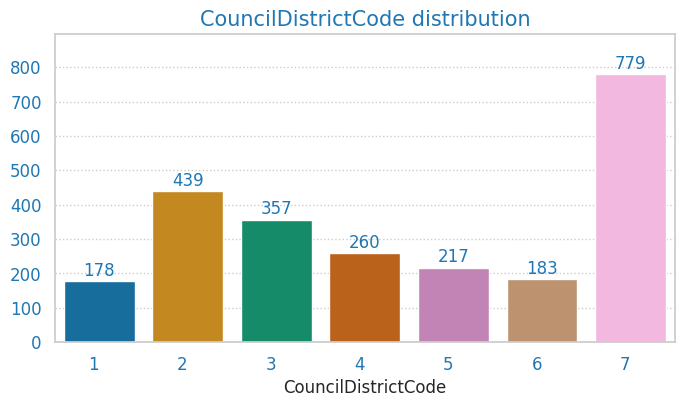

In [53]:
graph_distribution_modalités(df_MI,'CouncilDistrictCode',
                                figsize = (8,4),
                                label_size = 12,
                                container_size = 12,
                                title_size = 15, rotation = 0)

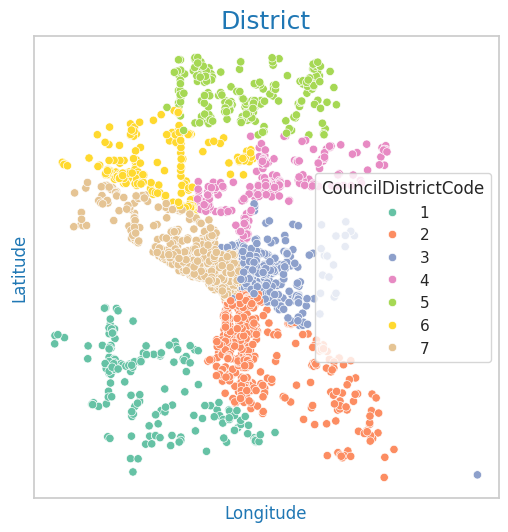

In [55]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sns.scatterplot(data = df_MI, x = 'Longitude', y ='Latitude', hue= 'CouncilDistrictCode', palette="Set2")
plt.title('District',fontsize = 18, color = 'tab:blue')
plt.xticks([])
plt.yticks([])   
#plt.xticks(rotation = 90,color = 'tab:blue')
#plt.yticks(color = 'tab:blue')
plt.xlabel('Longitude',color = 'tab:blue')
plt.ylabel('Latitude',color = 'tab:blue')
plt.show()

#### Year of built

In [56]:
df_MI['YearBuilt'].nunique()

113

In [57]:
X =df_MI['YearBuilt'].sort_values().value_counts(sort=False)
data = np.array([X.values])
columns = X.index
df_graph = pd.DataFrame(data = data, columns = columns)
df_graph

YearBuilt  1900  1901  1902  1903  1904  1905  1906  1907  1908  1909  ...  \
0            51     6    10     2    12     5    15    15    18    22  ...   

YearBuilt  2006  2007  2008  2009  2010  2011  2012  2013  2014  2015  
0            36    31    56    33    22    10    28    41    52    28  

[1 rows x 113 columns]

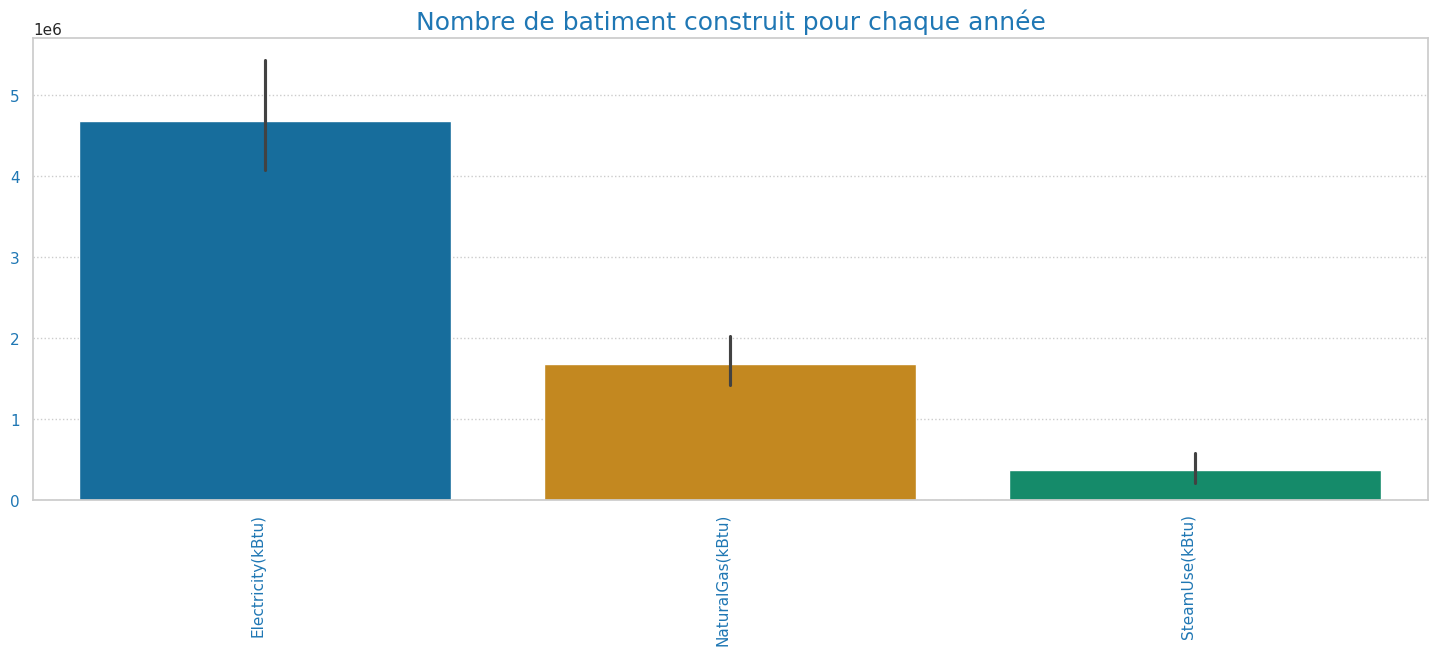

In [91]:
fig, ax = plt.subplots(1,1, figsize = (18,6))

sns.barplot(data = df_graph)

for xtick in ax.xaxis.get_ticklabels():
    xtick.set_rotation(90)
    xtick.set_color('tab:blue')
    xtick.set_ha('right')
    
for ytick in ax.yaxis.get_ticklabels():
    ytick.set_color('tab:blue')
    ytick.set_ha('right')    

plt.title('Nombre de batiment construit pour chaque année',
         fontsize = 18, color = 'tab:blue')
sns.despine
plt.show()

In [92]:
#création d'une palette de couleur en fonction de l année de construction
liste_color = sns.light_palette(color = "red", n_colors=df_MI['YearBuilt'].nunique(), 
                                reverse=True, as_cmap=False, input="rgb")

key_list = df_MI['YearBuilt'].sort_values(ascending = True).unique()
value_list = list(liste_color)

palette = dict(zip(key_list, value_list))

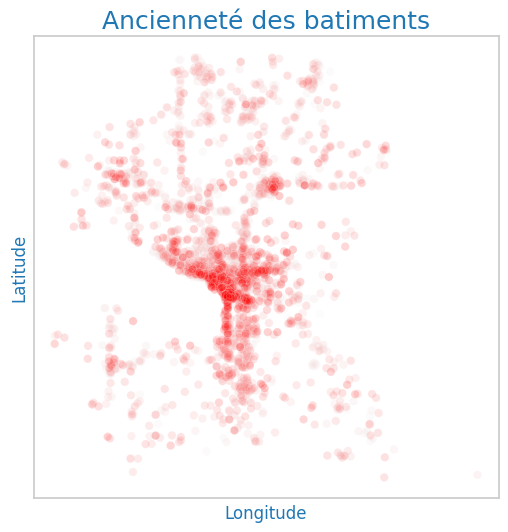

In [93]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sns.scatterplot(data = df_MI.sort_values(by = 'YearBuilt', ascending = False), x = 'Longitude', y ='Latitude', hue= 'YearBuilt', 
                palette = palette, alpha = 0.2)

ax.legend([],[], frameon=False)
plt.title('Ancienneté des batiments',
         fontsize = 18, color = 'tab:blue')
plt.xticks([])
plt.yticks([])
#plt.xticks(rotation = 90,color = 'tab:blue')
#plt.yticks(color = 'tab:blue')
plt.xlabel('Longitude',color = 'tab:blue')
plt.ylabel('Latitude',color = 'tab:blue')
plt.show()
#plus le rouge est foncé plus le batiments est ancien

#### Nombre d'étage

In [94]:
X =df_MI['NumberofFloors'].sort_values().value_counts(sort=False)
data = np.array([X.values])
columns = X.index
df_graph = pd.DataFrame(data = data, columns = columns)
df_graph

NumberofFloors  0    1    2    3    4    5    6    7   8   9   ...  41  42  \
0               13  460  398  395  363  193  217  111  47  13  ...   3   5   

NumberofFloors  46  47  49  55  56  63  76  99  
0                1   1   1   1   1   1   1   1  

[1 rows x 48 columns]

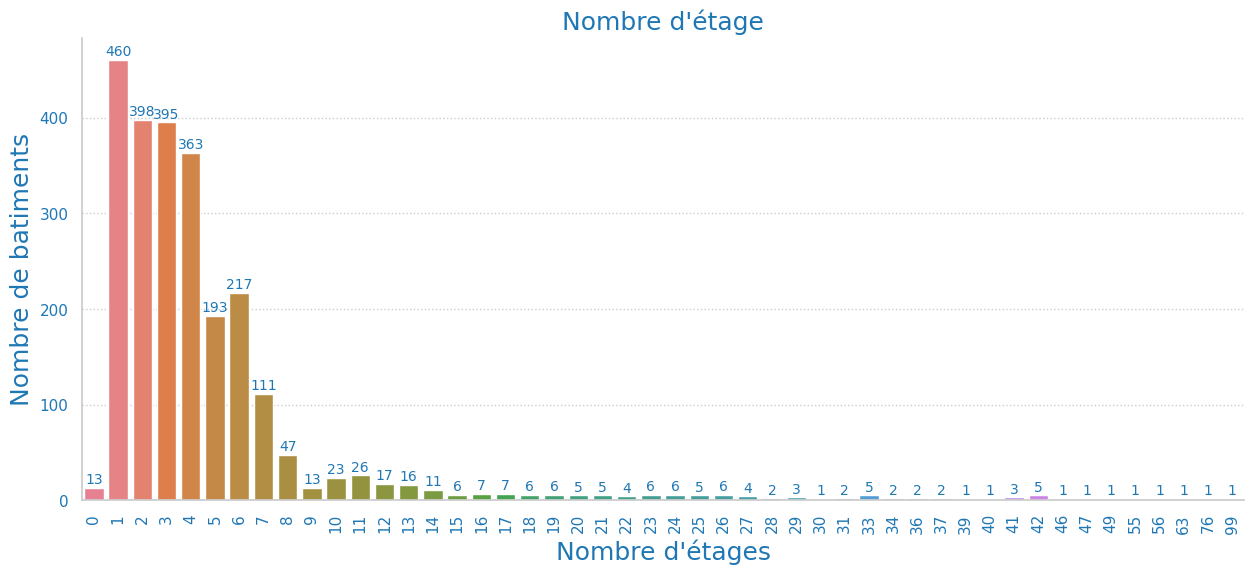

In [96]:
fig ,ax = plt.subplots(1,1, figsize = (15,6))
g = sns.barplot(data = df_graph)

for container in ax.containers:
    ax.bar_label(container, padding=1, color = 'tab:blue', size = 10)

plt.title("Nombre d'étage",
         fontsize = 18, color = 'tab:blue')
plt.xticks(rotation = 90,color = 'tab:blue')
plt.yticks(color = 'tab:blue')
plt.xlabel("Nombre d'étages",color = 'tab:blue',fontsize = 18)
plt.ylabel("Nombre de batiments",color = 'tab:blue',fontsize = 18)
sns.despine()
plt.show()

In [97]:
#création d'une palette de couleur en fonction du nombre d'étage
liste_color = sns.light_palette(color = "red", n_colors=df_MI['NumberofFloors'].nunique(), 
                                reverse=False, as_cmap=False, input="rgb")

key_list = df_MI['NumberofFloors'].sort_values(ascending = True).unique()
value_list = list(liste_color)

palette = dict(zip(key_list, value_list))

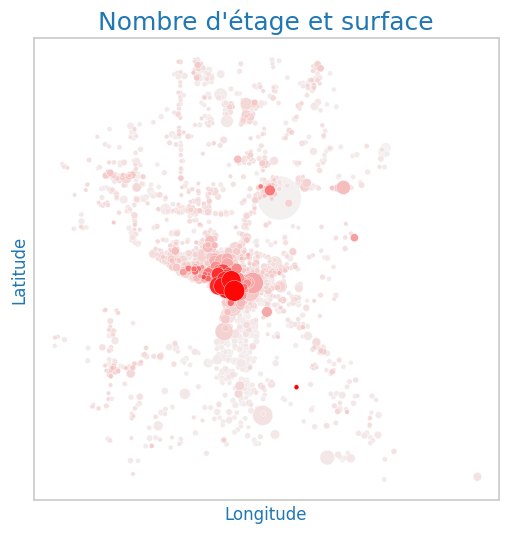

In [98]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sns.scatterplot(data = df_MI.sort_values(by ='NumberofFloors', ascending = True), x = 'Longitude', y ='Latitude', hue= 'NumberofFloors', 
                palette = palette, alpha = 1, size ='NonResidentialGFA' , sizes=(10, 1000))

ax.legend([],[], frameon=False)
plt.title("Nombre d'étage et surface",
         fontsize = 18, color = 'tab:blue')
plt.xticks([])
plt.yticks([])
#plt.xticks(rotation = 90,color = 'tab:blue')
#plt.yticks(color = 'tab:blue')
plt.xlabel('Longitude',color = 'tab:blue')
plt.ylabel('Latitude',color = 'tab:blue')

plt.show()

Les immeubles avec un grand nombre d'étages sont concentrés dans le centre de la ville.
On remarque la présence d'une zone avec une grande surface (GFA) mais avec tres peu d'étages, cette zone correspond à l'université de seattle.(voir ci-dessous)

## 3.3 - Variables Float

In [99]:
df_MF = df_M.select_dtypes(include ='float64')
df_MF.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 2413 entries, 0 to 3375
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Latitude                         2413 non-null   float64
 1   Longitude                        2413 non-null   float64
 2   NumberofBuildings                2413 non-null   float64
 3   LargestPropertyUseTypeGFA        2413 non-null   float64
 4   SecondLargestPropertyUseTypeGFA  1618 non-null   float64
 5   ThirdLargestPropertyUseTypeGFA   587 non-null    float64
 6   ENERGYSTARScore                  1657 non-null   float64
 7   SiteEUI(kBtu/sf)                 2413 non-null   float64
 8   SiteEUIWN(kBtu/sf)               2412 non-null   float64
 9   SourceEUI(kBtu/sf)               2413 non-null   float64
 10  SourceEUIWN(kBtu/sf)             2413 non-null   float64
 11  SiteEnergyUse(kBtu)              2413 non-null   float64
 12  SiteEnergyUseWN(kBtu)    

###  3.3.1 - Description des variables

### 3.3.2 - Distribution

#### distribution site source

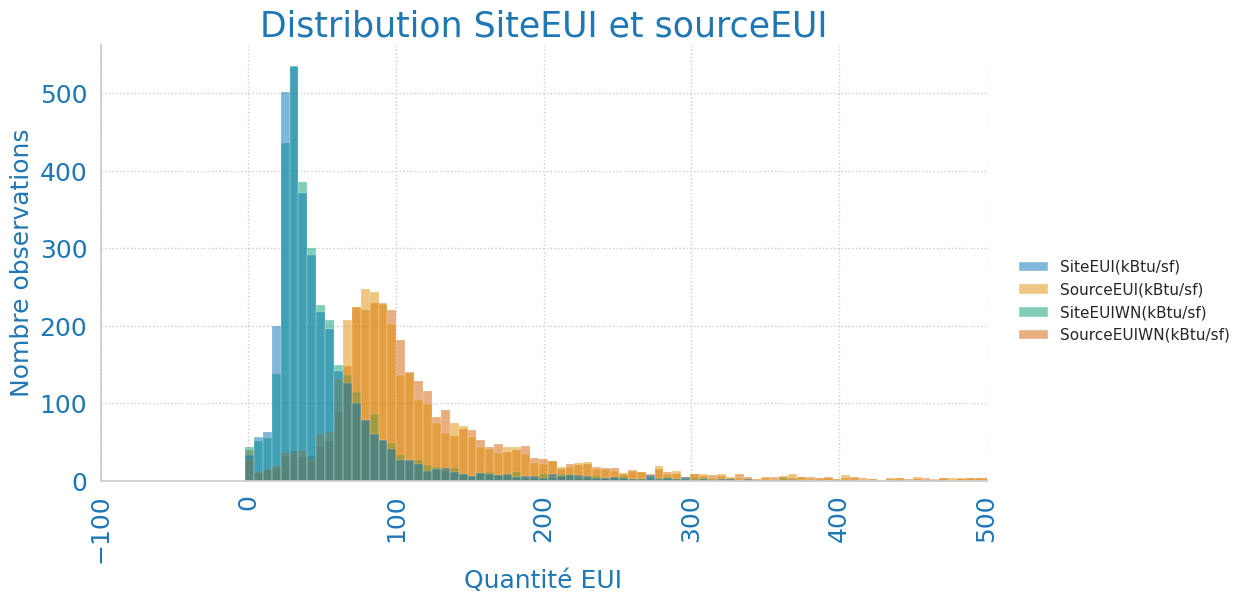

In [100]:
df_graph = df[['SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)','SourceEUIWN(kBtu/sf)']]
sns.displot(data = df_graph, height = 5, aspect = 2)
plt.xlim(-100,500)
plt.title("Distribution SiteEUI et sourceEUI",
         fontsize = 25, color = 'tab:blue')
plt.xticks(rotation = 90,color = 'tab:blue',fontsize = 18)
plt.yticks(color = 'tab:blue',fontsize = 18)
plt.ylabel('Nombre observations',color = 'tab:blue',fontsize = 18)
plt.xlabel('Quantité EUI',color = 'tab:blue',fontsize = 18)

plt.show()

In [101]:
df_graph.describe()

SiteEUI(kBtu/sf)  SourceEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  \
count       3369.000000         3367.000000         3370.000000   
mean          54.732116          134.232848           57.033798   
std           56.273124          139.287554           57.163330   
min            0.000000            0.000000            0.000000   
25%           27.900000           74.699997           29.400000   
50%           38.599998           96.199997           40.900002   
75%           60.400002          143.899994           64.275002   
max          834.400024         2620.000000          834.400024   

       SourceEUIWN(kBtu/sf)  
count           3367.000000  
mean             137.783932  
std              139.109807  
min               -2.100000  
25%               78.400002  
50%              101.099998  
75%              148.349998  
max             2620.000000

#### Type d'energie utilisé

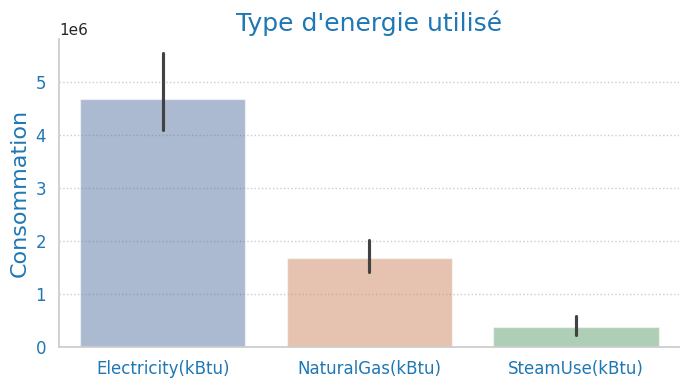

In [103]:
df_graph = df_M[['Electricity(kBtu)','NaturalGas(kBtu)','SteamUse(kBtu)']].sort_values(by = 'Electricity(kBtu)')
df_graph.reset_index(inplace = True)
df_graph.drop('index',axis = 1, inplace = True)
fig, ax = plt.subplots(1,1, figsize = (8,4))
sns.barplot(data = df_graph, palette = 'deep', alpha = 0.5)
sns.despine()

plt.title("Type d'energie utilisé",
         fontsize =18 , color = 'tab:blue')
plt.xticks(rotation = 0,color = 'tab:blue',fontsize = 12)
plt.yticks(color = 'tab:blue',fontsize = 12)
plt.ylabel('Consommation',color = 'tab:blue',fontsize = 16)


plt.show()

In [104]:
liste = ['PrimaryPropertyType','Electricity(kBtu)','NaturalGas(kBtu)','SteamUse(kBtu)','TotalGHGEmissions']
df_typeB_TypeE = df_M[liste].groupby(by ='PrimaryPropertyType').mean().round(2)
df_typeB_TypeE.sort_values(by = 'TotalGHGEmissions', ascending = False).head(10)

Electricity(kBtu)  NaturalGas(kBtu)  \
PrimaryPropertyType                                                
Hospital                           70711912.00       37694675.80   
University                         35894795.56        6994059.44   
Laboratory                         13475010.90        9715095.80   
Hotel                               6683622.63        4176516.99   
Mixed Use Property                  6640585.45        3952980.89   
Senior Care Community               4349089.09        4098985.20   
Medical Office                      8534714.00        2609586.08   
High-Rise Multifamily               6137713.84        3428725.10   
Supermarket / Grocery Store         6438735.35        3346005.12   
Restaurant                          2140905.55        3291215.36   

                             SteamUse(kBtu)  TotalGHGEmissions  
PrimaryPropertyType                                             
Hospital                        33140396.00            5052.96  
University                       3941658.36             925.94  
Laboratory                       3103019.40             849.42  
Hotel                            1980772.41             421.30  
Mixed Use Property                216327.29             272.93  
Senior Care Community             277975.38             269.47  
Medical Office                    827357.33             261.95  
High-Rise Multifamily             278848.72             246.41  
Supermarket / Grocery Store            0.00             222.59  
Restaurant                        228501.75             207.36

In [105]:
df_typeB_TypeE.columns

Index(['Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)',
       'TotalGHGEmissions'],
      dtype='object')

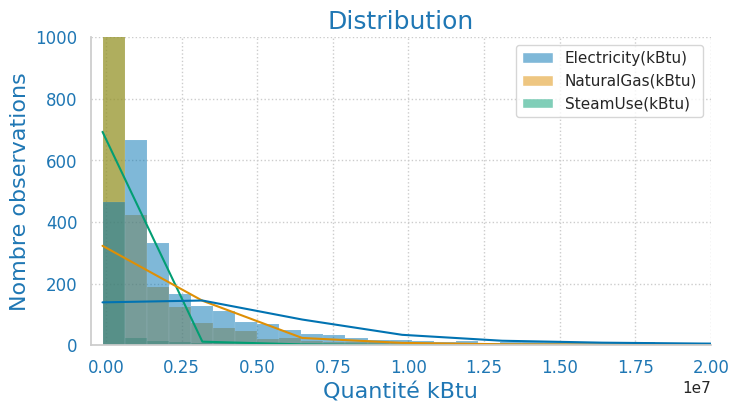

In [107]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
sns.histplot(data = df_graph, kde=True, bins = 900)

plt.title("Distribution",
         fontsize = 18, color = 'tab:blue')

plt.xticks(rotation = 0,color = 'tab:blue',fontsize = 12)
plt.yticks(color = 'tab:blue',fontsize = 12)
plt.ylabel('Nombre observations',color = 'tab:blue',fontsize = 16)
plt.xlabel('Quantité kBtu',color = 'tab:blue',fontsize = 16)

plt.xlim(-0.05*1e7,0.20*1e8)
plt.ylim(0,1000)
sns.despine()
plt.show()

#### ENERGYSTARScore

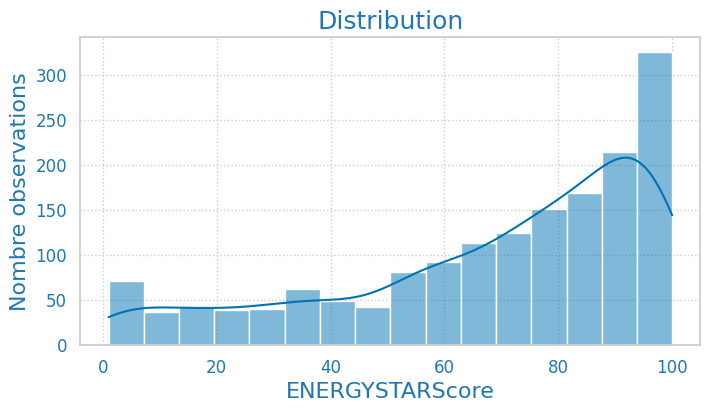

In [108]:
df_graph = df_MF['ENERGYSTARScore']
fig, ax = plt.subplots(1,1, figsize = (8,4))

sns.histplot(data = df_MF, x='ENERGYSTARScore', kde=True)
plt.title("Distribution",
         fontsize = 18, color = 'tab:blue')

plt.xticks(rotation = 0,color = 'tab:blue',fontsize = 12)
plt.yticks(color = 'tab:blue',fontsize = 12)
plt.ylabel('Nombre observations',color = 'tab:blue',fontsize = 16)
plt.xlabel('ENERGYSTARScore',color = 'tab:blue',fontsize = 16)
plt.show()

#### TotalGHGEmissions

In [109]:
df_MF['TotalGHGEmissions'].describe()

count     2413.000000
mean       150.863407
std        632.210688
min         -0.800000
25%         14.370000
50%         44.280000
75%        120.240000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

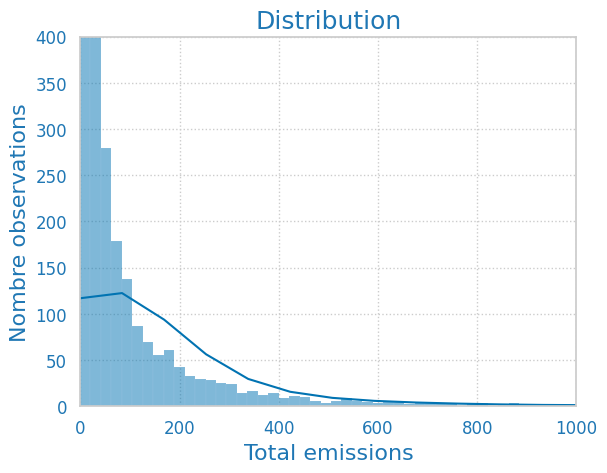

In [110]:
df_graph = df_MF['TotalGHGEmissions']

sns.histplot(data = df_MF, x='TotalGHGEmissions', kde=True, bins = 800)
                 
plt.title("Distribution",fontsize = 18, color = 'tab:blue')
plt.xticks(rotation = 0,color = 'tab:blue',fontsize = 12)
plt.yticks(color = 'tab:blue',fontsize = 12)
plt.ylabel('Nombre observations',color = 'tab:blue',fontsize = 16)
plt.xlabel('Total emissions',color = 'tab:blue',fontsize = 16)

plt.xlim(0,1000)
plt.ylim(0,400)

plt.show()                

In [114]:
df_M['TotalGHGEmissions_scaled']

KeyError: 'TotalGHGEmissions_scaled'

In [113]:
df_graph['TotalGHGEmissions_scaled'] = (df_MF['TotalGHGEmissions'] - df_MF['TotalGHGEmissions'].mean())/df_MF['TotalGHGEmissions'].std()

sns.histplot(data = df_graph, x='TotalGHGEmissions_scaled', kde=True, bins = 800)
                 
plt.title("Distribution",fontsize = 18, color = 'tab:blue')
plt.xticks(rotation = 0,color = 'tab:blue',fontsize = 12)
plt.yticks(color = 'tab:blue',fontsize = 12)
plt.ylabel('Nombre observations',color = 'tab:blue',fontsize = 16)
plt.xlabel('Total emissions',color = 'tab:blue',fontsize = 16)

plt.xlim(0,1000)
plt.ylim(0,400)

plt.show()  

TypeError: Data source must be a DataFrame or Mapping, not <class 'pandas.core.series.Series'>.

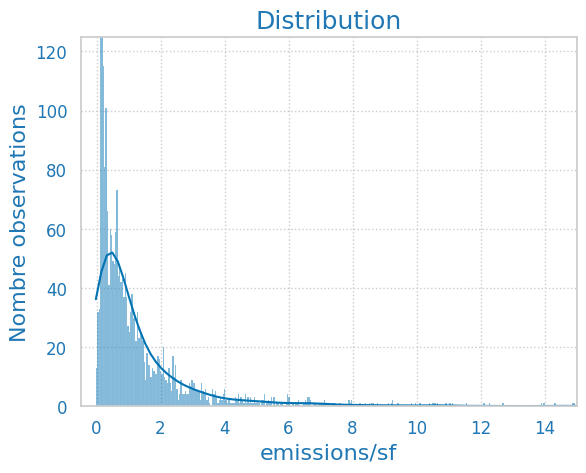

In [115]:
df_graph = df_MF['GHGEmissionsIntensity']

sns.histplot(data = df_MF, x='GHGEmissionsIntensity', kde=True, bins = 800)
                 
plt.title("Distribution",fontsize = 18, color = 'tab:blue')
plt.xticks(rotation = 0,color = 'tab:blue',fontsize = 12)
plt.yticks(color = 'tab:blue',fontsize = 12)
plt.ylabel('Nombre observations',color = 'tab:blue',fontsize = 16)
plt.xlabel('emissions/sf',color = 'tab:blue',fontsize = 16)

plt.xlim(-0.5,15)
plt.ylim(0,125)

plt.show()

## 3.4 - Analyse multivariée

In [116]:
liste_analyse= ('BuildingType','PrimaryPropertyType','Delta_Site_Source','delta_Source_WM','delta_Site_WM','PropertyGFATotal',
                'YearBuilt','SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','GHGEmissionsIntensity','ComplianceStatus',
                'LargestPropertyUseType','SecondLargestPropertyUseType')

#### Création de variables pour l analyse

#### Variation entre les différents types de mesures

In [117]:
df_M['delta_Site_WM'] = (df_M['SiteEUI(kBtu/sf)'] - df_M['SiteEUIWN(kBtu/sf)'])
df_M['delta_Source_WM'] = (df_M['SourceEUI(kBtu/sf)'] - df_M['SourceEUIWN(kBtu/sf)'])
df_M['Delta_Site_Source'] = (df_M['SiteEUI(kBtu/sf)'] - df_M['SourceEUI(kBtu/sf)'])
df_M['Delta_Site_Source_WN'] = (df_M['SiteEUIWN(kBtu/sf)'] - df_M['SourceEUIWN(kBtu/sf)'])
df_M['ratio_Site_Source_WN'] = df_M['Delta_Site_Source_WN'] / df_M['SiteEUIWN(kBtu/sf)']

#### Proportions des types energetiques utilisées

In [118]:
df_M['NaturalGaz_p'] = df_M['NaturalGas(kBtu)'] / (df_M['NaturalGas(kBtu)']+df_M['SteamUse(kBtu)']+df_M['Electricity(kBtu)'])
df_M['Electricity_p'] = df_M['Electricity(kBtu)'] / (df_M['NaturalGas(kBtu)']+df_M['SteamUse(kBtu)']+df_M['Electricity(kBtu)'])

### 3.4.1 - Année de construction et GHGEmissionsIntensity

### 3.4.2 - Nombre d'étage et GHGEmissionsIntensity

In [119]:
df_NbreEtage = df_M[['GHGEmissionsIntensity','NumberofFloors']].groupby(by = 'NumberofFloors').mean()

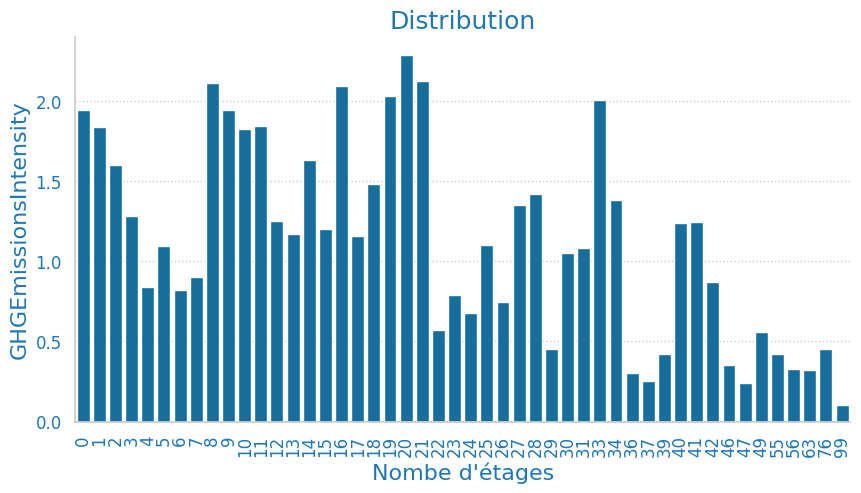

In [121]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
sns.barplot(data = df_NbreEtage, x = df_NbreEtage.index, y = 'GHGEmissionsIntensity')

for xtick in ax.xaxis.get_ticklabels():
    xtick.set_color('tab:blue')
    xtick.set_rotation(90)
    xtick.set_ha('center')

plt.title("Distribution",fontsize = 18, color = 'tab:blue')
plt.xticks(rotation = 90,color = 'tab:blue',fontsize = 12)
plt.yticks(color = 'tab:blue',fontsize = 12)
plt.ylabel('GHGEmissionsIntensity',color = 'tab:blue',fontsize = 16)
plt.xlabel("Nombe d'étages",color = 'tab:blue',fontsize = 16)

sns.despine()
plt.show()

Text(0.5, 0, "Nombe d'étages")

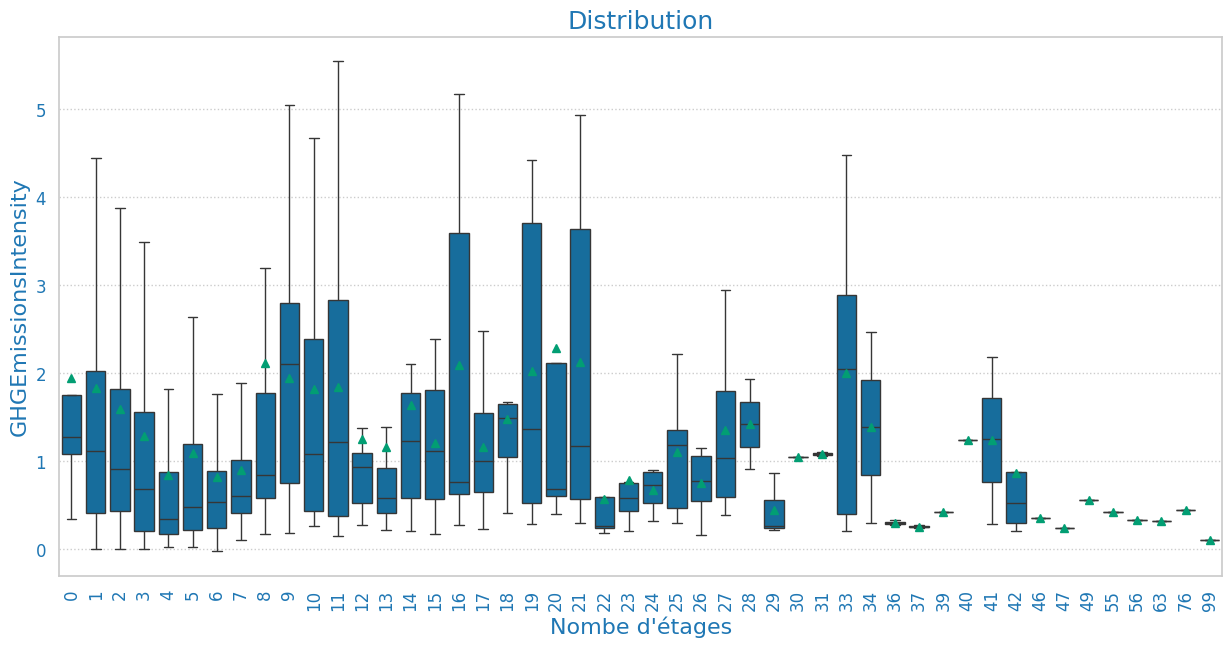

In [122]:
fix, ax = plt.subplots(1,1, figsize=(15,7))
data = df_M[['GHGEmissionsIntensity','NumberofFloors']]
sns.boxplot(data = data , x = 'NumberofFloors', y = 'GHGEmissionsIntensity', showfliers = False, showmeans = True)

for xtick in ax.xaxis.get_ticklabels():
    xtick.set_color('tab:blue')
    xtick.set_rotation(90)
    xtick.set_ha('center')

plt.title("Distribution",fontsize = 18, color = 'tab:blue')
plt.xticks(rotation = 90,color = 'tab:blue',fontsize = 12)
plt.yticks(color = 'tab:blue',fontsize = 12)
plt.ylabel('GHGEmissionsIntensity',color = 'tab:blue',fontsize = 16)
plt.xlabel("Nombe d'étages",color = 'tab:blue',fontsize = 16)

Text(0.5, 0, 'LargestPropertyUseType')

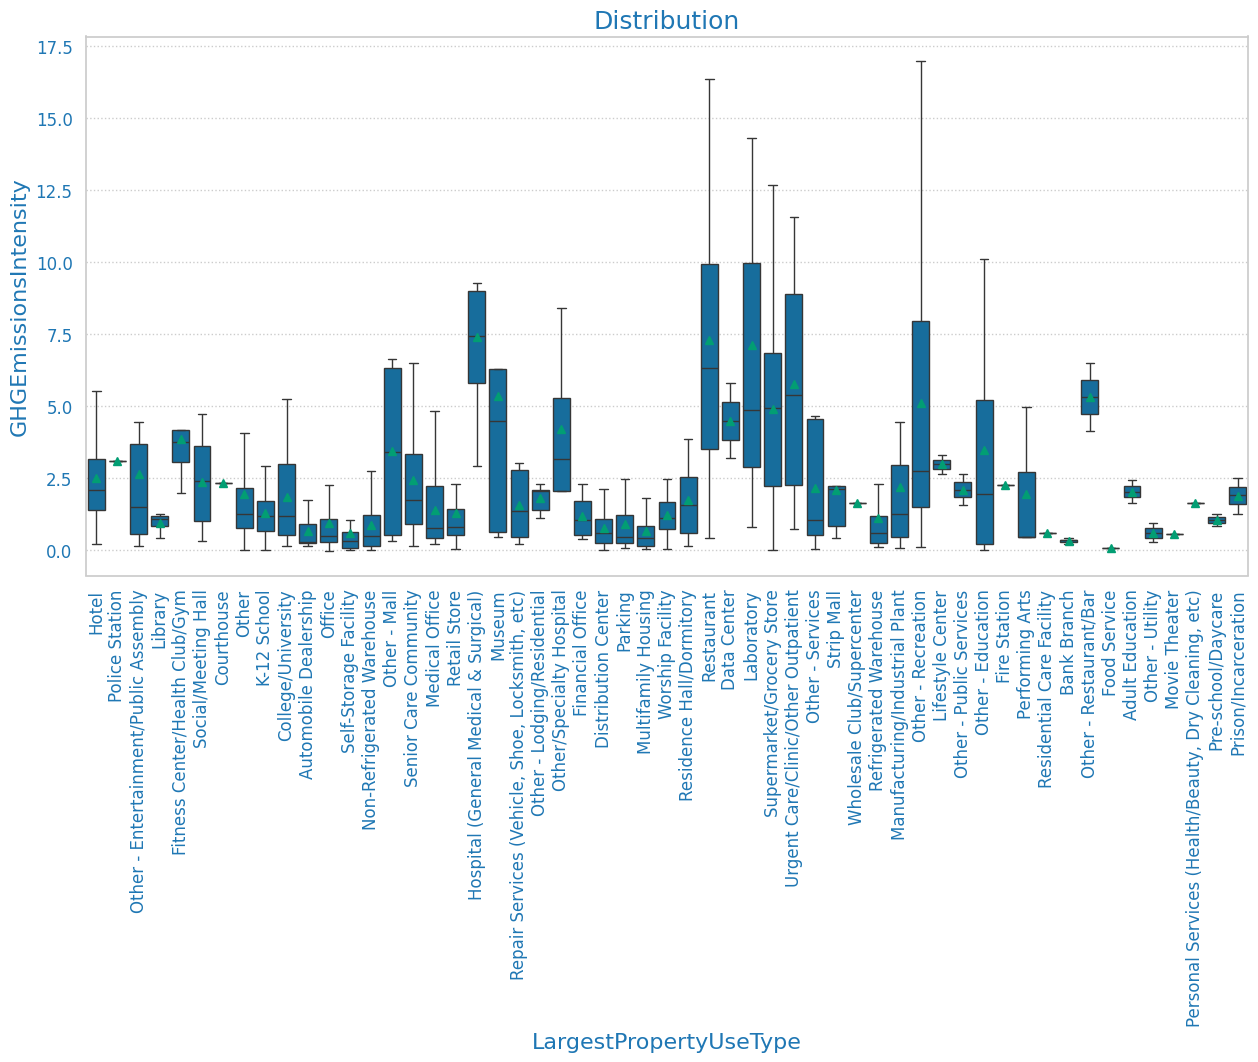

In [123]:
fix, ax = plt.subplots(1,1, figsize=(15,7))
data = df_M[['GHGEmissionsIntensity','LargestPropertyUseType']]
sns.boxplot(data = data , x = 'LargestPropertyUseType', y = 'GHGEmissionsIntensity', showfliers = False, showmeans = True)

for xtick in ax.xaxis.get_ticklabels():
    xtick.set_color('tab:blue')
    xtick.set_rotation(90)
    xtick.set_ha('center')

plt.title("Distribution",fontsize = 18, color = 'tab:blue')
plt.xticks(rotation = 90,color = 'tab:blue',fontsize = 12)
plt.yticks(color = 'tab:blue',fontsize = 12)
plt.ylabel('GHGEmissionsIntensity',color = 'tab:blue',fontsize = 16)
plt.xlabel('LargestPropertyUseType',color = 'tab:blue',fontsize = 16)

Text(0.5, 0, 'YearBuilt')

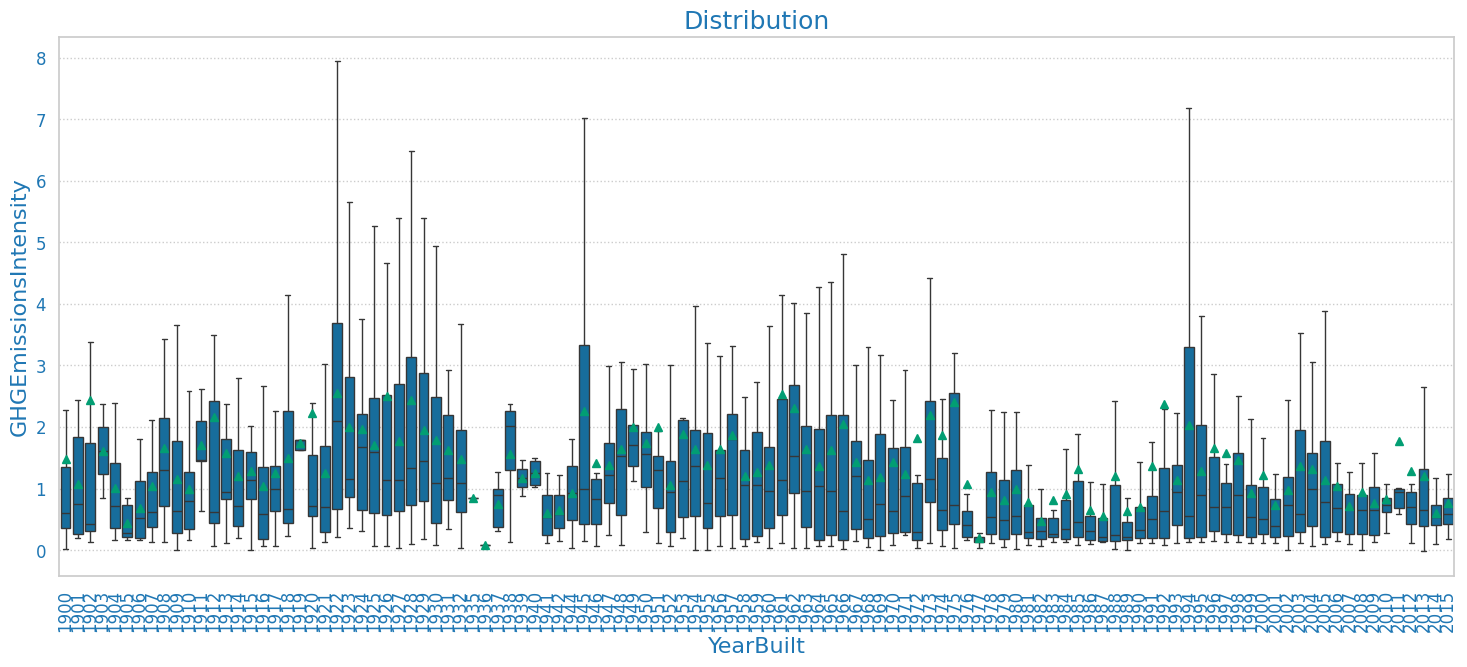

In [124]:
fix, ax = plt.subplots(1,1, figsize=(18,7))
data = df_M[['GHGEmissionsIntensity','YearBuilt']]
sns.boxplot(data = data , x = 'YearBuilt', y = 'GHGEmissionsIntensity', showfliers = False, showmeans = True)

for xtick in ax.xaxis.get_ticklabels():
    xtick.set_color('tab:blue')
    xtick.set_rotation(90)
    xtick.set_ha('center')

plt.title("Distribution",fontsize = 18, color = 'tab:blue')
plt.xticks(rotation = 90,color = 'tab:blue',fontsize = 12)
plt.yticks(color = 'tab:blue',fontsize = 12)
plt.ylabel('GHGEmissionsIntensity',color = 'tab:blue',fontsize = 16)
plt.xlabel('YearBuilt',color = 'tab:blue',fontsize = 16)

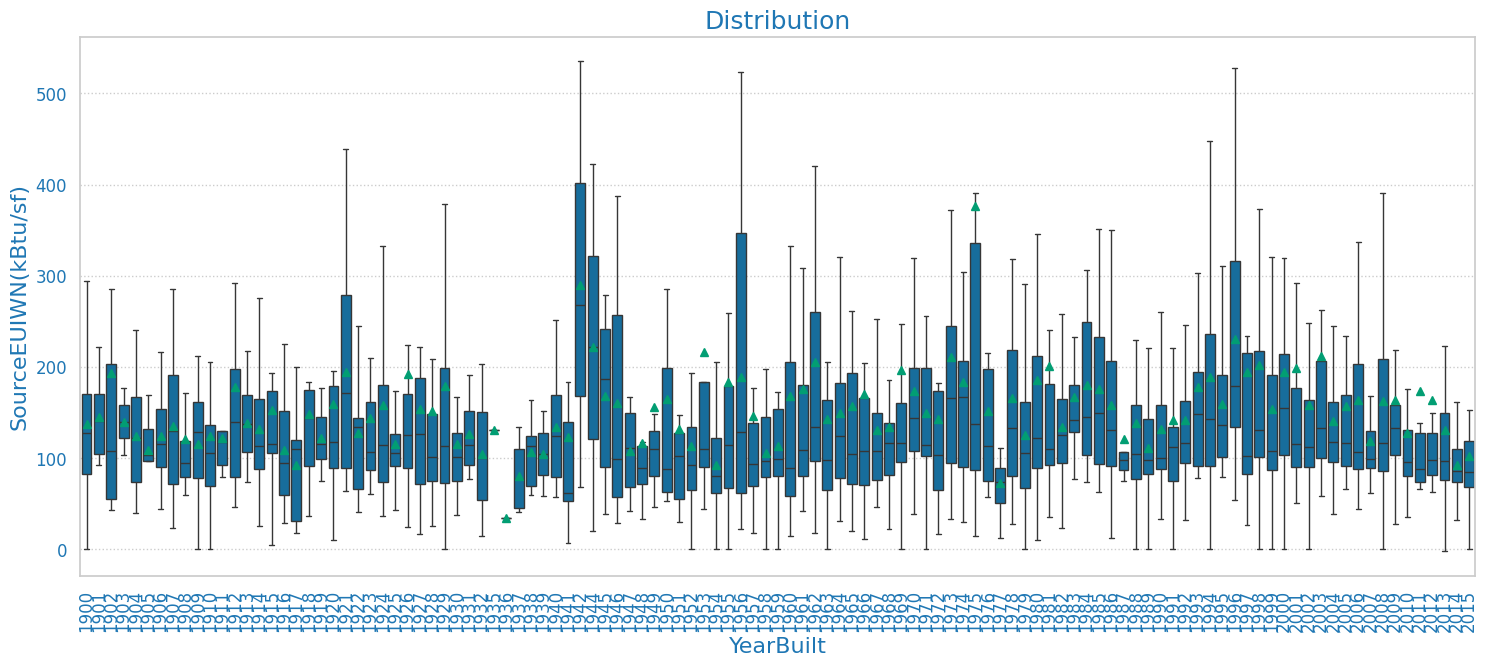

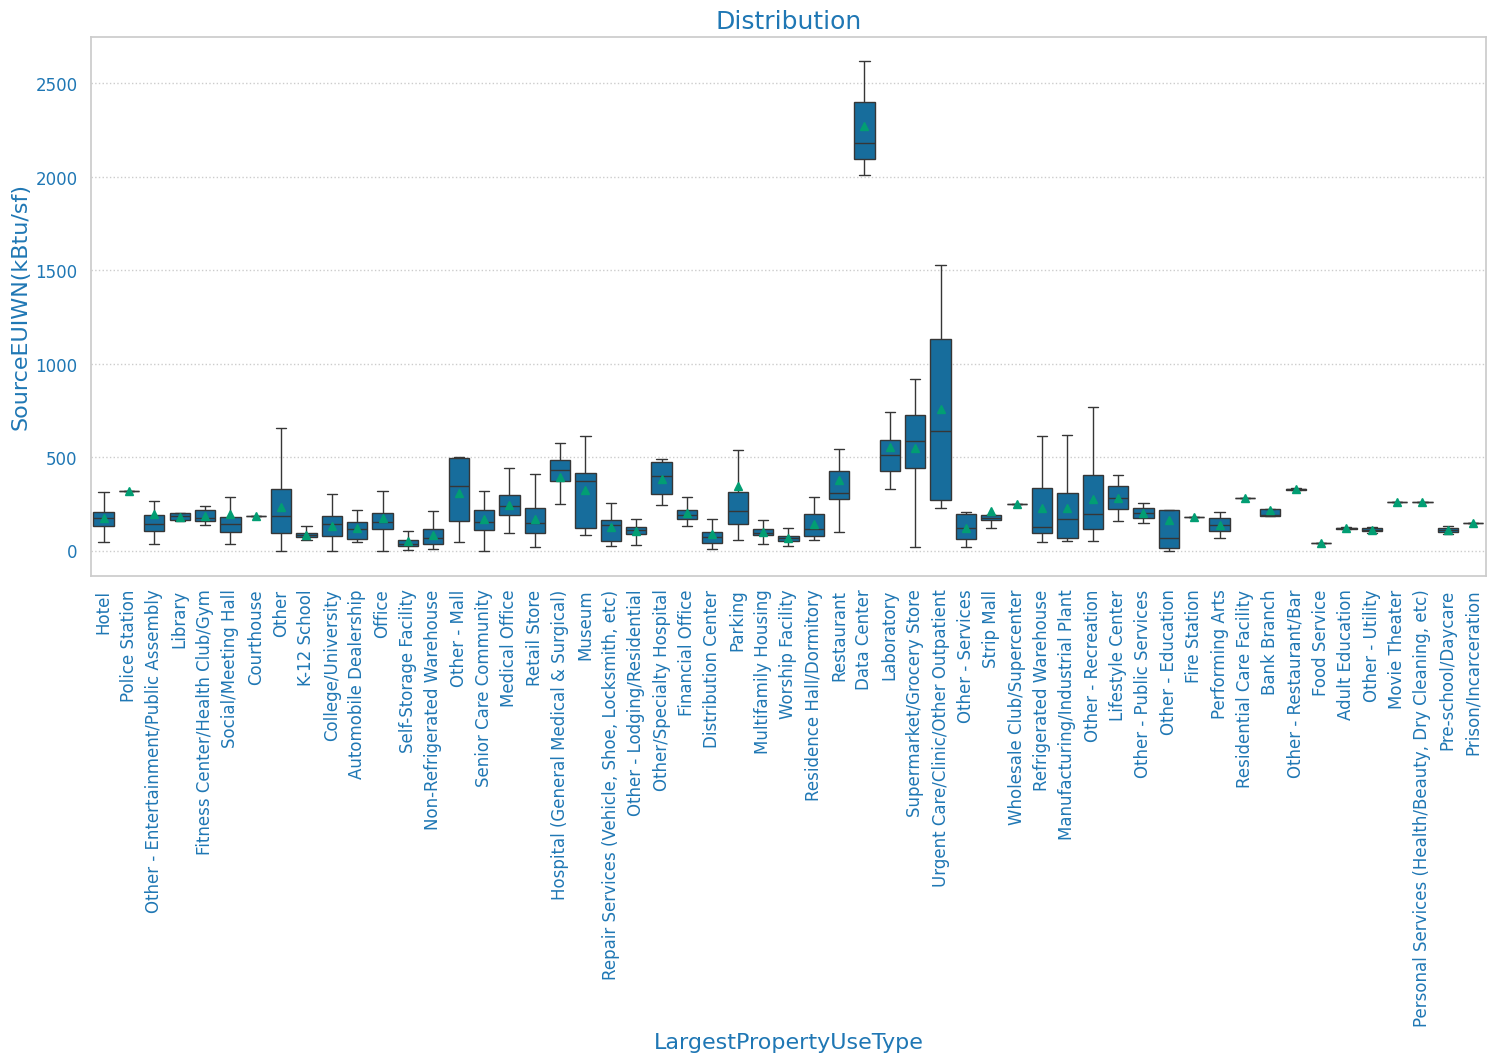

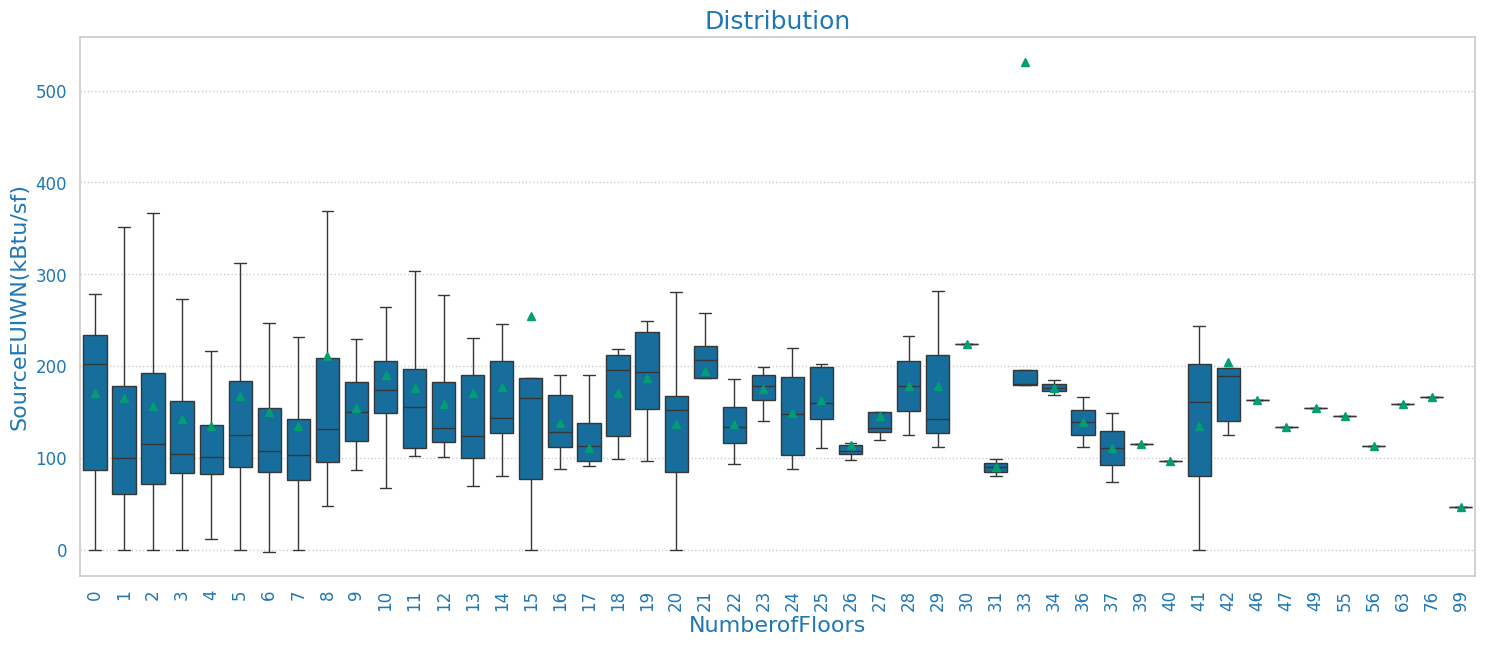

In [125]:
for champ in ['YearBuilt','LargestPropertyUseType','NumberofFloors']:
    fix, ax = plt.subplots(1,1, figsize=(18,7))
    data = df_M[['SourceEUIWN(kBtu/sf)',champ]]
    sns.boxplot(data = data , x = champ, y = 'SourceEUIWN(kBtu/sf)', showfliers = False, showmeans = True)

    for xtick in ax.xaxis.get_ticklabels():
        xtick.set_color('tab:blue')
        xtick.set_rotation(90)
        xtick.set_ha('center')

    plt.title("Distribution",fontsize = 18, color = 'tab:blue')
    plt.xticks(rotation = 90,color = 'tab:blue',fontsize = 12)
    plt.yticks(color = 'tab:blue',fontsize = 12)
    plt.ylabel('SourceEUIWN(kBtu/sf)',color = 'tab:blue',fontsize = 16)
    plt.xlabel(champ,color = 'tab:blue',fontsize = 16)

In [126]:
#focus sur le nombre d'etage = 33
cond = df_M.loc[:,'NumberofFloors'] == 33
df_M.loc[:,liste_analyse][cond].sort_values(by = 'GHGEmissionsIntensity')

BuildingType    PrimaryPropertyType  Delta_Site_Source  \
1083  Multifamily HR (10+)  High-Rise Multifamily         -63.400000   
206         NonResidential           Large Office        -129.200001   
13          NonResidential                  Hotel        -104.399994   
1079  Multifamily HR (10+)  High-Rise Multifamily         -71.500000   
558         NonResidential                  Other       -1368.200012   

      delta_Source_WM  delta_Site_WM  PropertyGFATotal  YearBuilt  \
1083        -1.500000      -0.500000            299755       2006   
206         -6.399994      -2.100002            791396       1976   
13          -0.800003      -0.699997            315952       1980   
1079       -12.399994      -9.899994            190610       1981   
558         -0.099976      -0.099976            429405       1981   

      SiteEUI(kBtu/sf)  SourceEUI(kBtu/sf)  GHGEmissionsIntensity  \
1083         29.600000           93.000000                   0.21   
206          60.299999          189.500000                   0.40   
13           75.500000          179.899994                   2.05   
1079         95.800003          167.300003                   2.89   
558         639.700012         2007.900024                   4.48   

     ComplianceStatus LargestPropertyUseType SecondLargestPropertyUseType  
1083        Compliant    Multifamily Housing                 Retail Store  
206         Compliant                 Office                      Parking  
13          Compliant                  Hotel                      Parking  
1079        Compliant    Multifamily Housing                      Parking  
558         Compliant            Data Center                       Office

### 3.4.3 - ENERGYSTARScore et GHGEmissionsIntensity

In [127]:
df_graph = df_M[['TotalGHGEmissions','GHGEmissionsIntensity','SourceEUIWN(kBtu/sf)','ENERGYSTARScore', 'BuildingType',]]

In [128]:
cond = df_graph['TotalGHGEmissions']< 200
df_graph = df_graph[cond]

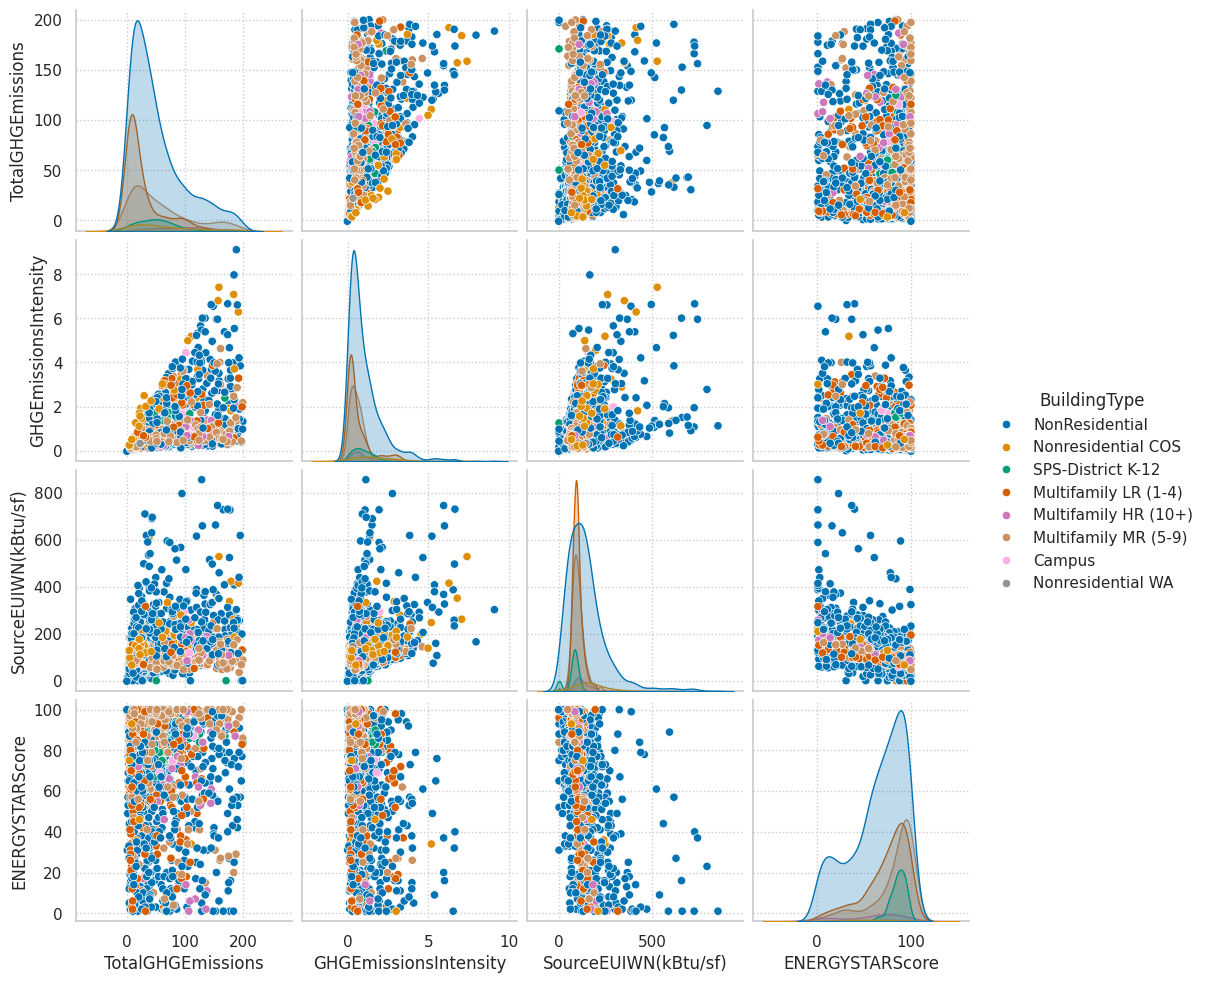

In [129]:
sns.pairplot(data = df_graph, hue='BuildingType')
plt.show()

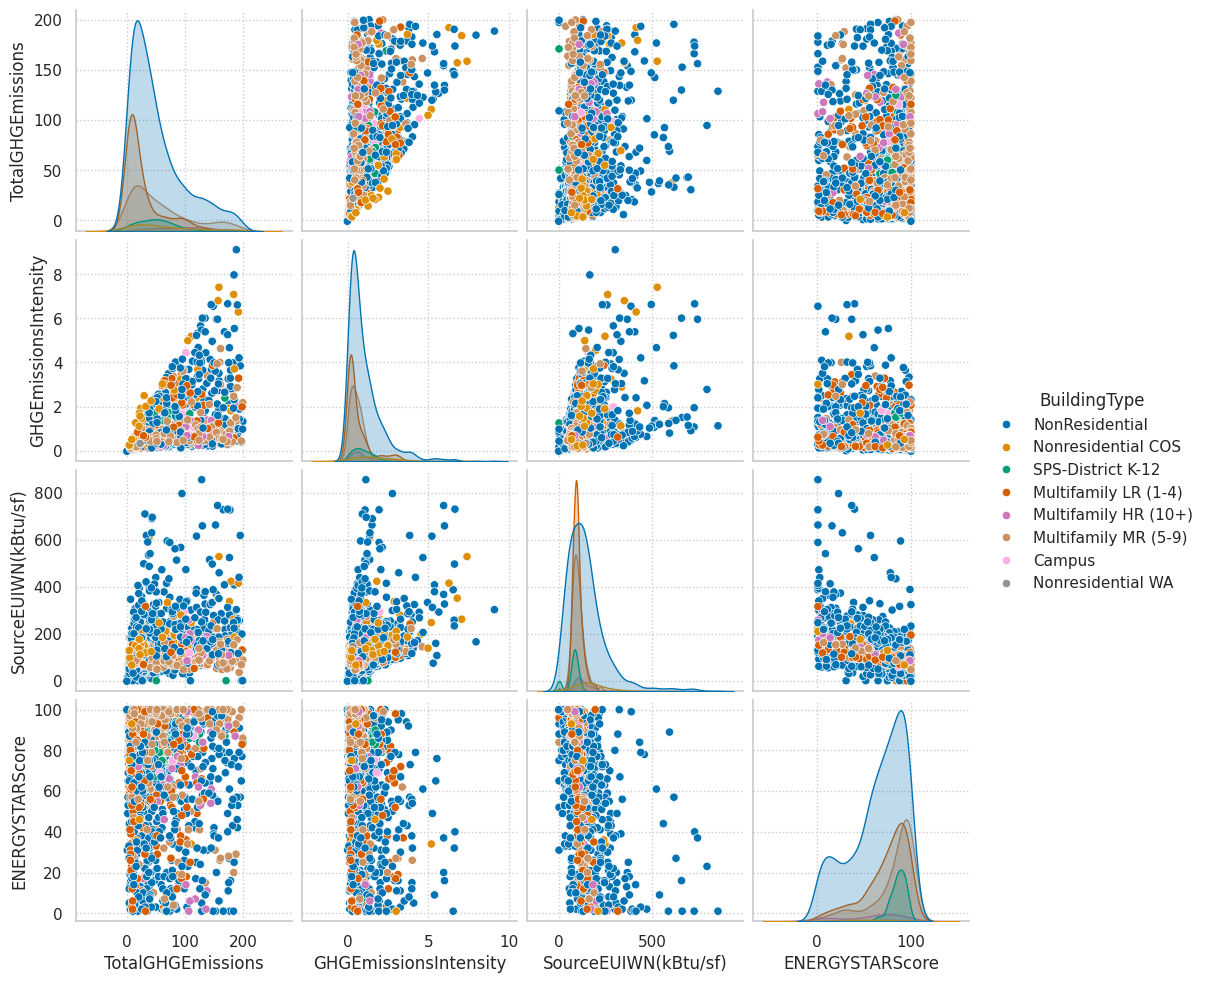

In [130]:
sns.pairplot(data = df_graph, hue='BuildingType')
plt.show()

/home/bryan/datascience/datascience/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/home/bryan/datascience/datascience/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
/home/bryan/datascience/datascience/lib/python3.10/site-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)


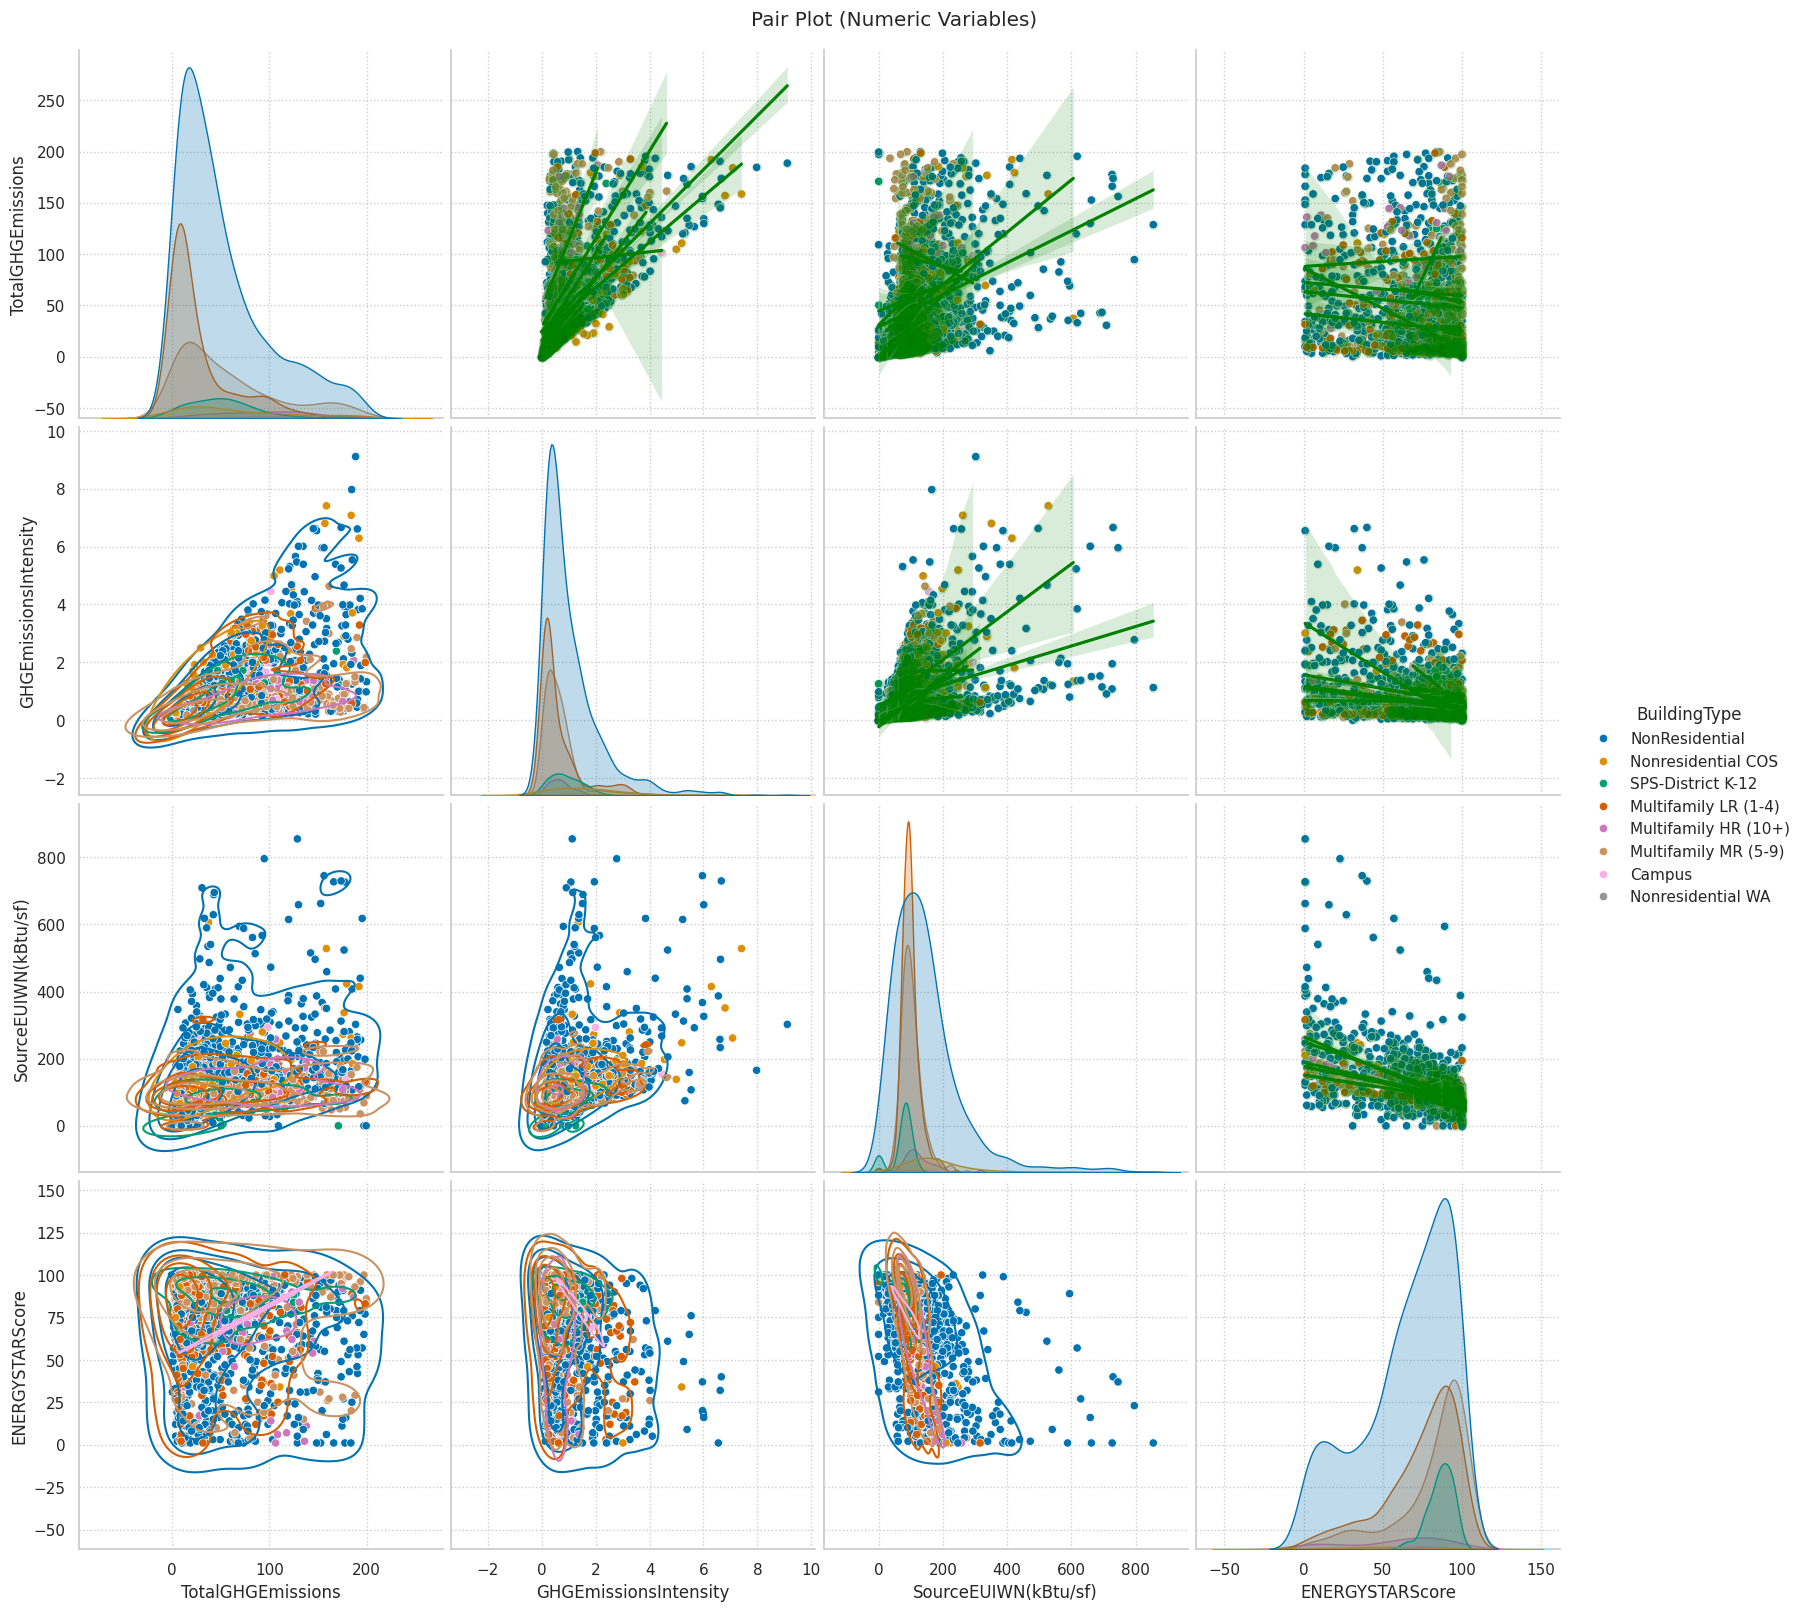

In [136]:
g = sns.pairplot(
    data = df_graph,
    height=4, 
    corner=False,
    hue='BuildingType',
)
g.map_lower(sns.kdeplot, levels=5,color ='red')
g.map_upper(sns.regplot, color='green', scatter_kws={'alpha': 0.1})
g.fig.suptitle('Pair Plot (Numeric Variables)', y=1.01);

### 3.4.4 - SourceEUI versus SiteEUI et impact de la normalisation météorologique

In [137]:
df_M['Delta_Site_Source'].describe()

count    2413.000000
mean      -89.551513
std        99.621401
min     -1785.599976
25%      -101.699997
50%       -64.600002
75%       -44.000000
max       208.800003
Name: Delta_Site_Source, dtype: float64

In [138]:
#focus sur les plus grandes variations positives
cond = df_M['Delta_Site_Source'] > 0
df_M.loc[:,liste_analyse][cond].head(5).sort_values(by='Delta_Site_Source', ascending = False)

BuildingType          PrimaryPropertyType  Delta_Site_Source  \
513         NonResidential  Supermarket / Grocery Store         208.800003   
505   Multifamily MR (5-9)         Mid-Rise Multifamily          55.599998   
755   Multifamily MR (5-9)         Mid-Rise Multifamily          37.000000   
1883  Multifamily LR (1-4)        Senior Care Community          35.400002   
2761        NonResidential                 Retail Store          23.400000   

      delta_Source_WM  delta_Site_WM  PropertyGFATotal  YearBuilt  \
513          0.000000      -5.300003             57176       2008   
505          0.000000      -2.900002            228288       2002   
755          0.000000      -1.900002             86525       1994   
1883         0.000000      -1.500000            144682       2008   
2761        -1.300001      -2.200001             24550       1917   

      SiteEUI(kBtu/sf)  SourceEUI(kBtu/sf)  GHGEmissionsIntensity  \
513         208.800003                 0.0                   0.00   
505          55.599998                 0.0                   0.06   
755          37.000000                 0.0                   0.15   
1883         35.400002                 0.0                   0.17   
2761         39.799999                16.4                   0.27   

     ComplianceStatus     LargestPropertyUseType SecondLargestPropertyUseType  
513         Compliant  Supermarket/Grocery Store                 Retail Store  
505         Compliant        Multifamily Housing                      Parking  
755         Compliant        Multifamily Housing                      Parking  
1883        Compliant      Senior Care Community                   Restaurant  
2761        Compliant               Retail Store                       Office

In [139]:
#focus sur les plus grandes variations négatives
cond = df_M['Delta_Site_Source'] < - 1000
df_M.loc[:,liste_analyse][cond].head(5).sort_values(by='Delta_Site_Source')

BuildingType PrimaryPropertyType  Delta_Site_Source  delta_Source_WM  \
240   NonResidential               Other       -1785.599976         0.000000   
309   NonResidential  Mixed Use Property       -1510.500061         0.000000   
3203  NonResidential               Other       -1486.600037         0.000000   
558   NonResidential               Other       -1368.200012        -0.099976   

      delta_Site_WM  PropertyGFATotal  YearBuilt  SiteEUI(kBtu/sf)  \
240        0.000000             36000       1969        834.400024   
309        0.000000            213834       2001        707.299988   
3203       0.000000             90679       1975        694.700012   
558       -0.099976            429405       1981        639.700012   

      SourceEUI(kBtu/sf)  GHGEmissionsIntensity ComplianceStatus  \
240          2620.000000                   5.82        Compliant   
309          2217.800049                   2.48        Compliant   
3203         2181.300049                   3.20        Compliant   
558          2007.900024                   4.48        Compliant   

     LargestPropertyUseType SecondLargestPropertyUseType  
240             Data Center                          NaN  
309                 Parking                  Data Center  
3203            Data Center                      Parking  
558             Data Center                       Office

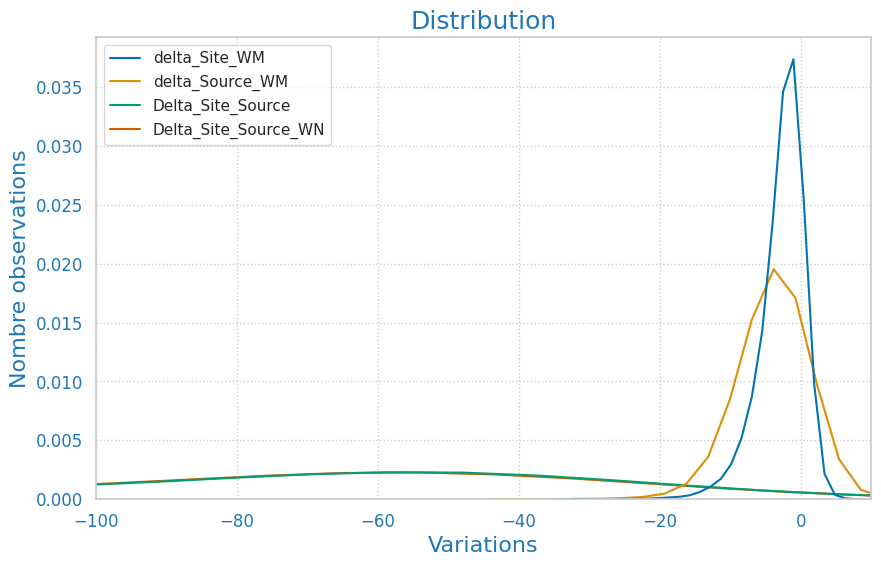

In [140]:
df_graph = pd.DataFrame(
    {'delta_Site_WM' : df_M['delta_Site_WM'],
     'delta_Source_WM' : df_M['delta_Source_WM'],
     'Delta_Site_Source' : df_M['Delta_Site_Source'],
     'Delta_Site_Source_WN' : df_M['Delta_Site_Source_WN']
    }
)



fig, ax = plt.subplots(1,1, figsize = (10,6))
sns.kdeplot(data = df_graph)

plt.title("Distribution",fontsize = 18, color = 'tab:blue')
plt.xticks(rotation = 0,color = 'tab:blue',fontsize = 12)
plt.yticks(color = 'tab:blue',fontsize = 12)
plt.ylabel('Nombre observations',color = 'tab:blue',fontsize = 16)
plt.xlabel('Variations',color = 'tab:blue',fontsize = 16)

plt.xlim(-100,10)
plt.show()

In [141]:
df_graph = df_M[['PrimaryPropertyType','Delta_Site_Source','delta_Source_WM','delta_Site_WM']].groupby('PrimaryPropertyType').mean()
df_graph

Delta_Site_Source  delta_Source_WM  delta_Site_WM
PrimaryPropertyType                                                           
Distribution Center                 -51.228301        -2.884907      -2.613207
High-Rise Multifamily               -68.772059        -3.482353      -1.805882
Hospital                           -220.680002        22.150003       4.329997
Hotel                               -87.662666        -2.866666      -1.958666
K-12 School                         -39.517518        -5.372993      -4.176642
Laboratory                         -315.549993        -1.790006      -6.069995
Large Office                       -126.252942         2.008824       0.073373
Low-Rise Multifamily                -56.948837        -4.876163      -2.069477
Medical Office                     -151.617949        -1.348718      -1.533334
Mid-Rise Multifamily                -57.660625        -3.454062      -1.653125
Mixed Use Property                 -126.272727        -3.797727      -3.066667
Office                              -70.066666        -9.966667      -4.466667
Other                              -143.688095        -4.414683      -3.905159
Refrigerated Warehouse             -153.141667         2.374998       0.083334
Residence Hall                      -65.428571        -4.100000      -2.085715
Restaurant                         -162.972724        -5.754551      -4.736366
Retail Store                       -105.452809        -2.014607      -2.266293
Self-Storage Facility               -24.174073        -2.770371      -2.051852
Senior Care Community               -84.211110        -5.644447      -3.571111
Small- and Mid-Sized Office        -101.697917        -3.048264      -2.148611
Supermarket / Grocery Store        -319.235001        -5.447492      -6.292499
University                          -92.616000        36.464001      13.304000
Warehouse                           -45.813903        -3.377006      -2.791979
Worship Facility                    -28.737681        -3.302899      -3.350725

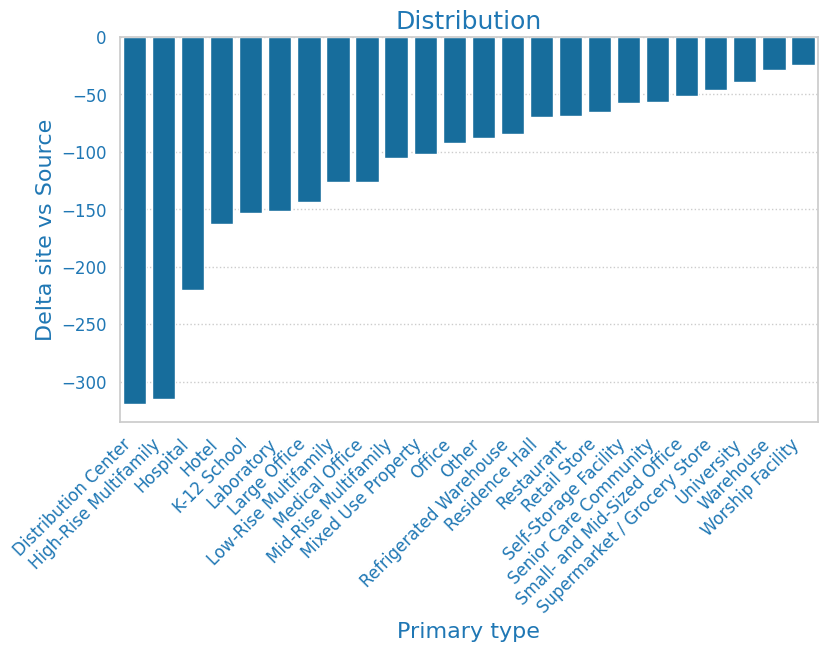

In [142]:
plt.figure(figsize = (9,5))
sns.barplot(data = df_graph.sort_values(by = 'Delta_Site_Source'), x = df_graph.index, y = 'Delta_Site_Source')

plt.title("Distribution",fontsize = 18, color = 'tab:blue')
plt.xticks(color = 'tab:blue', rotation = 45, ha = 'right',fontsize = 12)
plt.yticks(color = 'tab:blue',fontsize = 12)
plt.ylabel('Delta site vs Source',color = 'tab:blue',fontsize = 16)
plt.xlabel('Primary type',color = 'tab:blue',fontsize = 16)

plt.show()

In [143]:
#nous regardons les corrélations entre les potentielles variables explicatives.
corr_matrice = df_M[['SiteEUIWN(kBtu/sf)','SourceEUIWN(kBtu/sf)','ratio_Site_Source_WN','Delta_Site_Source','delta_Source_WM','delta_Site_WM']].corr()
corr_matrice

SiteEUIWN(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
SiteEUIWN(kBtu/sf)              1.000000              0.941747   
SourceEUIWN(kBtu/sf)            0.941747              1.000000   
ratio_Site_Source_WN            0.187770             -0.058613   
Delta_Site_Source              -0.844038             -0.971794   
delta_Source_WM                -0.066282             -0.047968   
delta_Site_WM                  -0.180070             -0.107010   

                      ratio_Site_Source_WN  Delta_Site_Source  \
SiteEUIWN(kBtu/sf)                0.187770          -0.844038   
SourceEUIWN(kBtu/sf)             -0.058613          -0.971794   
ratio_Site_Source_WN              1.000000           0.207234   
Delta_Site_Source                 0.207234           1.000000   
delta_Source_WM                  -0.146818          -0.069516   
delta_Site_WM                    -0.488952          -0.037074   

                      delta_Source_WM  delta_Site_WM  
SiteEUIWN(kBtu/sf)          -0.066282      -0.180070  
SourceEUIWN(kBtu/sf)        -0.047968      -0.107010  
ratio_Site_Source_WN        -0.146818      -0.488952  
Delta_Site_Source           -0.069516      -0.037074  
delta_Source_WM              1.000000       0.961038  
delta_Site_WM                0.961038       1.000000

### 3.4.7 - Matrice de variance covariance

In [144]:
df_M.shape

(2413, 43)

In [146]:
y_SiteEUI = df['SiteEUI(kBtu/sf)'].values
y_TotalGHGE= df['TotalGHGEmissions'].values
y_IntGHGE = df['GHGEmissionsIntensity'].values

numeric_features = ['LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA',
                    'NaturalGaz_p', 'Electricity_p','Latitude','Longitude', 'NumberofBuildings',
                    'NumberofFloors','PropertyGFAParking', 'PropertyGFABuilding(s)','NonResidentialGFA']
categorical_features = ['PrimaryPropertyType','BuildingType',
                        'LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType']
features = numeric_features + categorical_features + ['SourceEUIWN(kBtu/sf)']

In [147]:
df_M.isna().sum()

BuildingType                          0
PrimaryPropertyType                   0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
LargestPropertyUseType                0
LargestPropertyUseTypeGFA             0
SecondLargestPropertyUseType        795
SecondLargestPropertyUseTypeGFA     795
ThirdLargestPropertyUseType        1826
ThirdLargestPropertyUseTypeGFA     1826
ENERGYSTARScore                     756
SiteEUI(kBtu/sf)                      0
SiteEUIWN(kBtu/sf)                    1
SourceEUI(kBtu/sf)                    0
SourceEUIWN(kBtu/sf)                  0
SiteEnergyUse(kBtu)                   0
SiteEnergyUseWN(kBtu)                 1


In [154]:
#supression des NaN pour les colonnes Electricity_p, naturalGaz_p et SiteEUIWN(kBtu/sf)
cond = df_M['NaturalGaz_p'].isna()
rqdIndex = df_M[cond].index
df_M.drop(rqdIndex, axis = 0, inplace = True)

cond = df_M['SiteEUIWN(kBtu/sf)'].isna()
rqdIndex = df_M[cond].index
df_M.drop(rqdIndex, axis = 0, inplace = True)

cond = df_M['ratio_Site_Source_WN'].isna()
rqdIndex = df_M[cond].index
df_M.drop(rqdIndex, axis = 0, inplace = True)

In [155]:
#on remplace les NaN par 0 pour ThirdLargestPropertyUseTypeGFA et secondLargestPropertyUseTypeGFA
df_M['ThirdLargestPropertyUseTypeGFA'] = df_M['ThirdLargestPropertyUseTypeGFA'].fillna(0)
df_M['SecondLargestPropertyUseTypeGFA'] = df_M['SecondLargestPropertyUseTypeGFA'].fillna(0)
df_M['ThirdLargestPropertyUseType'] = df_M['ThirdLargestPropertyUseType'].fillna('NoGFA')
df_M['SecondLargestPropertyUseType'] = df_M['SecondLargestPropertyUseType'].fillna('NoGFA')

In [159]:
features

['LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'NaturalGaz_p',
 'Electricity_p',
 'Latitude',
 'Longitude',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'NonResidentialGFA',
 'PrimaryPropertyType',
 'BuildingType',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'SourceEUIWN(kBtu/sf)']

In [160]:
df_M[features]

LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
0                       88434.0                              0.0   
1                       83880.0                          15064.0   
2                      756493.0                              0.0   
3                       61320.0                              0.0   
4                      123445.0                          68009.0   
...                         ...                              ...   
3371                    12294.0                              0.0   
3372                    16000.0                              0.0   
3373                     7583.0                           5574.0   
3374                     6601.0                           6501.0   
3375                     8271.0                           8000.0   

      ThirdLargestPropertyUseTypeGFA  NaturalGaz_p  Electricity_p  Latitude  \
0                                0.0      0.176638       0.546060  47.61220   
1                             4622.0      0.613391       0.386609  47.61317   
2                                0.0      0.020579       0.682307  47.61393   
3                                0.0      0.266567       0.407519  47.61412   
4                                0.0      0.621198       0.378802  47.61375   
...                              ...           ...            ...       ...   
3371                             0.0      0.383026       0.616974  47.56722   
3372                             0.0      0.582704       0.417296  47.59625   
3373                             0.0      0.689180       0.310820  47.63644   
3374                           484.0      0.515102       0.484898  47.52832   
3375                          1108.0      0.624811       0.375189  47.53939   

      Longitude  NumberofBuildings  NumberofFloors  PropertyGFAParking  \
0    -122.33799                1.0              12                   0   
1    -122.33393                1.0              11               15064   
2    -122.33810                1.0              41              196718   
3    -122.33664                1.0              10                   0   
4    -122.34047                1.0              18               62000   
...         ...                ...             ...                 ...   
3371 -122.31154                1.0               1                   0   
3372 -122.32283                1.0               1                   0   
3373 -122.35784                1.0               1                   0   
3374 -122.32431                1.0               1                   0   
3375 -122.29536                1.0               1                   0   

      PropertyGFABuilding(s)  NonResidentialGFA PrimaryPropertyType  \
0                      88434              88434               Hotel   
1                      88502             103566               Hotel   
2                     759392             756493               Hotel   
3                      61320              61320               Hotel   
4                     113580             191454               Hotel   
...                      ...                ...                 ...   
3371                   12294              12294              Office   
3372                   16000              16000               Other   
3373                   13157              13157               Other   
3374                   14101              13586  Mixed Use Property   
3375                   18258              17379  Mixed Use Property   

            BuildingType LargestPropertyUseType  \
0         NonResidential                  Hotel   
1         NonResidential                  Hotel   
2         NonResidential                  Hotel   
3         NonResidential                  Hotel   
4         NonResidential                  Hotel   
...                  ...                    ...   
3371  Nonresidential COS                 Office   
3372  Nonresidential COS     Other - Recreation   
3373  Nonresidential COS     Other - Re

In [162]:
#nous regardons les corrélations entre les potentielles variables explicatives.
numeric_cols = df_M[features].select_dtypes(exclude=['object', 'string'])
corr_matrix = numeric_cols.corr()
corr_matrice

SiteEUIWN(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
SiteEUIWN(kBtu/sf)              1.000000              0.941747   
SourceEUIWN(kBtu/sf)            0.941747              1.000000   
ratio_Site_Source_WN            0.187770             -0.058613   
Delta_Site_Source              -0.844038             -0.971794   
delta_Source_WM                -0.066282             -0.047968   
delta_Site_WM                  -0.180070             -0.107010   

                      ratio_Site_Source_WN  Delta_Site_Source  \
SiteEUIWN(kBtu/sf)                0.187770          -0.844038   
SourceEUIWN(kBtu/sf)             -0.058613          -0.971794   
ratio_Site_Source_WN              1.000000           0.207234   
Delta_Site_Source                 0.207234           1.000000   
delta_Source_WM                  -0.146818          -0.069516   
delta_Site_WM                    -0.488952          -0.037074   

                      delta_Source_WM  delta_Site_WM  
SiteEUIWN(kBtu/sf)          -0.066282      -0.180070  
SourceEUIWN(kBtu/sf)        -0.047968      -0.107010  
ratio_Site_Source_WN        -0.146818      -0.488952  
Delta_Site_Source           -0.069516      -0.037074  
delta_Source_WM              1.000000       0.961038  
delta_Site_WM                0.961038       1.000000

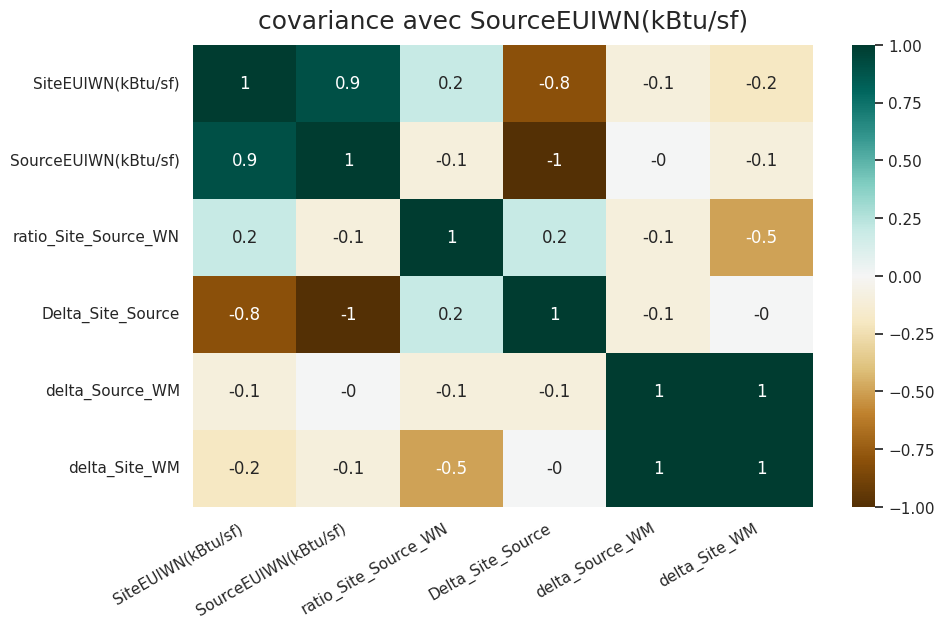

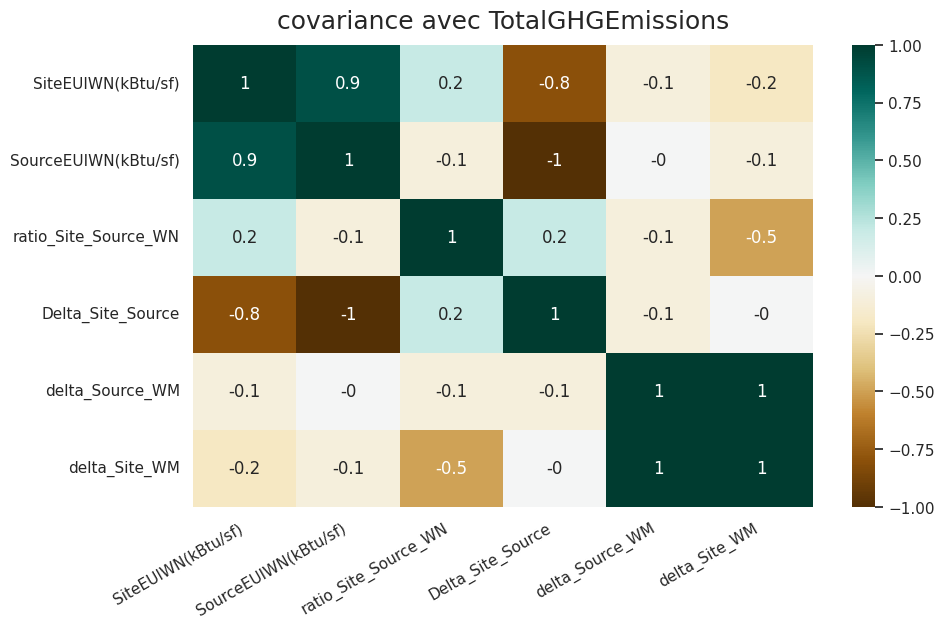

In [164]:
for champ in ['SourceEUIWN(kBtu/sf)','TotalGHGEmissions']:
    
    
    #features = numeric_features + categorical_features + [champ]
    
    #corr_matrice = df_M[features].corr()
    
    plt.figure(figsize=(10, 6))
    heatmap = sns.heatmap(corr_matrice.round(1), vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title(f"covariance avec {champ}", fontdict={'fontsize':18}, pad=12)
    plt.xticks(rotation = 30, ha = 'right')
    plt.show()

In [165]:
#df_M.to_csv('data/cleaned/df_clean2.csv')